# This notebook demonstrates plotting different types of MCS track statistics between OBS and Model for different seasons separately
## Require data: MCS final track statistics files
- mcs_tracks_final_*.nc

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.geoaxes as crs_geoaxes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import shapely.geometry as sgeom
import copy
import seaborn as sns
from sklearn.neighbors import KernelDensity
%matplotlib inline

## Specify region of interest, months, land/ocean MCS definition

In [2]:
# Select a region (Amazon, Argentina)
region = 'USA'

# Min number of MCS to plot
min_ntracks = 10

# MCS lifetime limits
lifetime_bounds = [2,60]

# PF land fraction threshold to separate land vs. ocean MCS
land_frac_thresh = 0.9
ocean_frac_thresh = 0.1

# Define region bounds
# box_usa = [-110,-70,30,50]
box_usa = [-110,-80,30,50]
# Months to include
months_usa = [3,4,5,6,7,8,9,10]

# Lookup region based on input
bounds_dict = {'USA':box_usa}
months_dict = {'USA':months_usa}
bounds = bounds_dict[region]
months = months_dict[region]
print(f'{region} lat/lon bounds: {bounds}')
print(f'{region} months: {months}')

USA lat/lon bounds: [-110, -80, 30, 50]
USA months: [3, 4, 5, 6, 7, 8, 9, 10]


### Show a map for the subset region

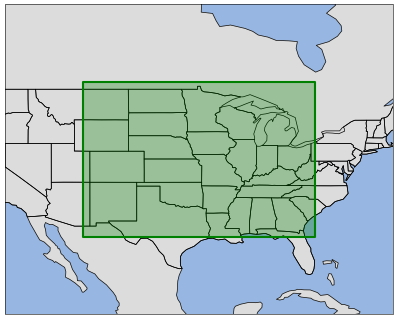

In [3]:
resolution = '110m'
map_extent = [bounds[0]-10,bounds[1]+10,bounds[2]-10,bounds[3]+10]
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', resolution)
proj = ccrs.PlateCarree(central_longitude=180)
box_proj = ccrs.PlateCarree(central_longitude=0)
fig = plt.figure(figsize=[10,10], dpi=50)
ax = plt.subplot(111, projection=proj)
ax.set_extent(map_extent, box_proj)
# Add land, coastlines, borders to inset
ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
ax.add_feature(borders, edgecolor='k', facecolor='none')
ax.add_feature(states, edgecolor='k', facecolor='none')
# Plot a box region in the inset
box = sgeom.box(minx=bounds[0], maxx=bounds[1], miny=bounds[2], maxy=bounds[3])
ax.add_geometries([box], box_proj, facecolor='none', edgecolor='g', lw=3)
ax.add_geometries([box], box_proj, facecolor='g', edgecolor='none', alpha=0.3)

## Specify input data location

In [4]:
# Specify years to include in the statistics
years = [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]

# Sepcify directory of the MCS track stats file
rootdir = '/pscratch/sd/s/souravt/PyFLEXTRKR/TGW_MCS/HIST/'
files_obs = []
files_m1 = []
for yy in years:
    files_obs = files_obs + sorted(glob.glob(f'{rootdir}OBS/stats/mcs_tracks_final_{yy}*.nc'))
    files_m1 = files_m1 + sorted(glob.glob(f'{rootdir}WRF/stats/mcs_tracks_final_{yy}*.nc'))
nfiles_obs = len(files_obs)
nfiles_wrf = len(files_m1)
print(f'Number of files (OBS): {nfiles_obs}')
print(f'Number of files (WRF): {nfiles_wrf}')

# Output figure directory
figdir = f'/global/cfs/cdirs/m2637/zfeng/TGW_MCS/figures/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

Number of files (OBS): 13
Number of files (WRF): 13
/global/cfs/cdirs/m2637/zfeng/TGW_MCS/figures/


In [5]:
files_obs

['/pscratch/sd/s/souravt/PyFLEXTRKR/TGW_MCS/HIST/OBS/stats/mcs_tracks_final_20040301.0000_20041101.0000.nc',
 '/pscratch/sd/s/souravt/PyFLEXTRKR/TGW_MCS/HIST/OBS/stats/mcs_tracks_final_20050301.0000_20051101.0000.nc',
 '/pscratch/sd/s/souravt/PyFLEXTRKR/TGW_MCS/HIST/OBS/stats/mcs_tracks_final_20060301.0000_20061101.0000.nc',
 '/pscratch/sd/s/souravt/PyFLEXTRKR/TGW_MCS/HIST/OBS/stats/mcs_tracks_final_20070301.0000_20071101.0000.nc',
 '/pscratch/sd/s/souravt/PyFLEXTRKR/TGW_MCS/HIST/OBS/stats/mcs_tracks_final_20080301.0000_20081101.0000.nc',
 '/pscratch/sd/s/souravt/PyFLEXTRKR/TGW_MCS/HIST/OBS/stats/mcs_tracks_final_20090301.0000_20091101.0000.nc',
 '/pscratch/sd/s/souravt/PyFLEXTRKR/TGW_MCS/HIST/OBS/stats/mcs_tracks_final_20100301.0000_20101101.0000.nc',
 '/pscratch/sd/s/souravt/PyFLEXTRKR/TGW_MCS/HIST/OBS/stats/mcs_tracks_final_20110301.0000_20111101.0000.nc',
 '/pscratch/sd/s/souravt/PyFLEXTRKR/TGW_MCS/HIST/OBS/stats/mcs_tracks_final_20120301.0000_20121101.0000.nc',
 '/pscratch/sd/s/so

In [6]:
files_m1

['/pscratch/sd/s/souravt/PyFLEXTRKR/TGW_MCS/HIST/WRF/stats/mcs_tracks_final_20040301.0000_20041101.0000.nc',
 '/pscratch/sd/s/souravt/PyFLEXTRKR/TGW_MCS/HIST/WRF/stats/mcs_tracks_final_20050301.0000_20051101.0000.nc',
 '/pscratch/sd/s/souravt/PyFLEXTRKR/TGW_MCS/HIST/WRF/stats/mcs_tracks_final_20060301.0000_20061101.0000.nc',
 '/pscratch/sd/s/souravt/PyFLEXTRKR/TGW_MCS/HIST/WRF/stats/mcs_tracks_final_20070301.0000_20071101.0000.nc',
 '/pscratch/sd/s/souravt/PyFLEXTRKR/TGW_MCS/HIST/WRF/stats/mcs_tracks_final_20080301.0000_20081101.0000.nc',
 '/pscratch/sd/s/souravt/PyFLEXTRKR/TGW_MCS/HIST/WRF/stats/mcs_tracks_final_20090301.0000_20091101.0000.nc',
 '/pscratch/sd/s/souravt/PyFLEXTRKR/TGW_MCS/HIST/WRF/stats/mcs_tracks_final_20100301.0000_20101101.0000.nc',
 '/pscratch/sd/s/souravt/PyFLEXTRKR/TGW_MCS/HIST/WRF/stats/mcs_tracks_final_20110301.0000_20111101.0000.nc',
 '/pscratch/sd/s/souravt/PyFLEXTRKR/TGW_MCS/HIST/WRF/stats/mcs_tracks_final_20120301.0000_20121101.0000.nc',
 '/pscratch/sd/s/so

In [7]:
# Read OBS data
dsobs = xr.open_mfdataset(files_obs, concat_dim='tracks', combine='nested').load()
# Renumber the tracks so they are unique
ntracks_obs = dsobs.dims['tracks']
dsobs['tracks'] = np.arange(0, ntracks_obs)
pixel_radius_obs = dsobs.attrs['pixel_radius_km']
# dsobs

/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/

In [8]:
# Read Model data
dsm1 = xr.open_mfdataset(files_m1, concat_dim='tracks', combine='nested').load()
# Renumber the tracks so they are unique
ntracks_wrf = dsm1.dims['tracks']
dsm1['tracks'] = np.arange(0, ntracks_wrf)
pixel_radius_m1 = dsm1.attrs['pixel_radius_km']
# Convert longitudes from 0~360 to -180~+180
dsm1['meanlon'] = ((dsm1.meanlon - 180) % 360) - 180
dsm1['pf_lon'] = ((dsm1.pf_lon - 180) % 360) - 180
dsm1['pf_lon_centroid'] = ((dsm1.pf_lon_centroid - 180) % 360) - 180
dsm1['pf_lon_weightedcentroid'] = ((dsm1.pf_lon_weightedcentroid - 180) % 360) - 180
# dsm1

/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/

## Custom functions for track selections

In [9]:
def find_track_in_region(start_basetime, lons, lats, lifetime, lon_bounds, lat_bounds, lifetime_bounds, smonth_vals):
    """
    Find tracks within a region, lifetime, and month bounds.
    """
    # Get the track initiation month and location
    start_month = start_basetime.dt.month
    start_lon = lons.isel(times=0)
    start_lat = lats.isel(times=0)

    # Find tracks that initiates within a region
    mcsidx = np.where(
        (start_lon >= min(lon_bounds)) & (start_lon <= max(lon_bounds)) & \
        (start_lat >= min(lat_bounds)) & (start_lat <= max(lat_bounds)) & \
        (lifetime >= min(lifetime_bounds)) & (lifetime <= max(lifetime_bounds)) & \
        (np.in1d(start_month, smonth_vals))
    )[0]
    return mcsidx

def get_land_ocean_ds(ds, trackidx, land_frac_thresh, ocean_frac_thresh):
    """
    Separate land vs. ocean tracks in Datasets.
    """
    # Subset tracks from Dataset
    ds = ds.isel(tracks=trackidx)

    # Calculate lifetime-mean PF land fraction
    init_landfrac = ds['pf_landfrac'].isel(times=slice(0,3)).mean(dim='times')
    avg_landfrac = ds['pf_landfrac'].mean(dim='times')
    # Separate land vs. ocean tracks
    mcsidx_land = np.where(avg_landfrac > land_frac_thresh)[0]
    mcsidx_ocean = np.where(avg_landfrac < ocean_frac_thresh)[0]
    # Subset tracks for land vs. ocean
    ds_l = ds.isel(tracks=mcsidx_land)
    ds_o = ds.isel(tracks=mcsidx_ocean)    
    return (ds_l, ds_o)

def find_merge_split_tracks(ds):
    """
    Find merge/split track indices.
    """
    # non-split tracks
    idx_nsplit = np.isnan(ds.start_split_cloudnumber)
    # non-merge tracks
    idx_nmerge = np.isnan(ds.end_merge_cloudnumber)
    # non-merge and non-split tracks
    idx_nms = np.isnan(ds.start_split_cloudnumber) & np.isnan(ds.end_merge_cloudnumber)
    # merge or split tracks
    idx_ms = ~np.isnan(ds.start_split_cloudnumber) | ~np.isnan(ds.end_merge_cloudnumber)
    # Group outputs to dictionary
    out_dict = {
        'ms': idx_ms,
        'nms': idx_nms,
        'nm': idx_nmerge,
        'ns': idx_nsplit,
    }
    return out_dict

## Subset tracks within a region and months

In [10]:
# Get time resolution of data
time_res_obs = dsobs.attrs['time_resolution_hour']
time_res_m1 = dsm1.attrs['time_resolution_hour']
# Convert track duration to physical lifetime
lifetime_obs = dsobs.track_duration * time_res_obs
lifetime_m1 = dsm1.track_duration * time_res_obs

# Subset MCS by region and lifetime
lon_bounds = [bounds[0],bounds[1]]
lat_bounds = [bounds[2],bounds[3]]
# lon_bounds, lat_bounds
mcsidx_obs = find_track_in_region(dsobs.start_basetime, dsobs.meanlon, dsobs.meanlat, lifetime_obs, lon_bounds, lat_bounds, lifetime_bounds, months)
print(f'Number of tracks (OBS): {len(mcsidx_obs)}')
mcsidx_m1 = find_track_in_region(dsm1.start_basetime, dsm1.meanlon, dsm1.meanlat, lifetime_m1, lon_bounds, lat_bounds, lifetime_bounds, months)
print(f'Number of tracks (WRF): {len(mcsidx_m1)}')

Number of tracks (OBS): 3483
Number of tracks (WRF): 2416


/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/core/accessor_dt.py:122: RuntimeWarning: invalid value encountered in cast
  return access_method(values, name).astype(dtype, copy=False)


(array([  0.,   0., 143., 218., 446., 456., 449., 357., 217., 130.,   0.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 <BarContainer object of 11 artists>)

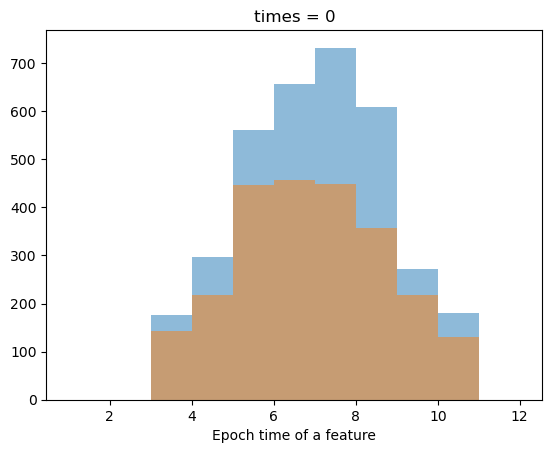

In [11]:
# Check the distribution of tracks by month
dsobs.base_time.dt.month.isel(tracks=mcsidx_obs, times=0).plot.hist(bins=np.arange(1,13,1), alpha=0.5)
dsm1.base_time.dt.month.isel(tracks=mcsidx_m1, times=0).plot.hist(bins=np.arange(1,13,1), alpha=0.5)

## Calculate mean/std of the number of MCSs by month
- Requires at least 3 years of data

In [12]:
# Get start basetime for the tracks
start_basetime_obs = dsobs.base_time.isel(tracks=mcsidx_obs, times=0)
start_basetime_m1 = dsm1.base_time.isel(tracks=mcsidx_m1, times=0)

nmonths = len(months)
nyears = len(years)
nmcs_month_avg_obs = np.ndarray(nmonths, dtype=np.float32)
nmcs_month_std_obs = np.ndarray(nmonths, dtype=np.float32)
nmcs_month_avg_m1 = np.ndarray(nmonths, dtype=np.float32)
nmcs_month_std_m1 = np.ndarray(nmonths, dtype=np.float32)

# Loop over each month
for im in range(0, nmonths):
    # Find startyear with the same months
    syear_obs_tmp = start_basetime_obs.dt.year.where(start_basetime_obs.dt.month == months[im], drop=True)
    syear_m1_tmp = start_basetime_m1.dt.year.where(start_basetime_m1.dt.month == months[im], drop=True)

    # Make a temporary array to count the number
    count_obs = np.ndarray(nyears, dtype=np.float32)
    count_m1 = np.ndarray(nyears, dtype=np.float32)

    # Loop over each year and save the count
    for iy in range(0, nyears):
        count_obs[iy] = syear_obs_tmp.where(syear_obs_tmp == years[iy], drop=True).count()
        count_m1[iy] = syear_m1_tmp.where(syear_m1_tmp == years[iy], drop=True).count()

    # Calculate average/std of counts for each month
    nmcs_month_avg_obs[im] = np.nanmean(count_obs)
    nmcs_month_std_obs[im] = np.nanstd(count_obs)
    nmcs_month_avg_m1[im] = np.nanmean(count_m1)
    nmcs_month_std_m1[im] = np.nanstd(count_m1)

## MCS Seasonal Cycle Counts

In [13]:
def get_month_names(month_numbers):
    """
    Get month names based on list of month numbers
    """
    month_dict = {
        1: 'Jan',
        2: 'Feb',
        3: 'Mar',
        4: 'Apr',
        5: 'May',
        6: 'Jun',
        7: 'Jul',
        8: 'Aug',
        9: 'Sep',
        10: 'Oct',
        11: 'Nov',
        12: 'Dec'
    }
    month_names = []
    for month_number in month_numbers:
        month_name = month_dict.get(month_number)
        month_names.append(month_name)
    return month_names

/global/cfs/cdirs/m2637/zfeng/TGW_MCS/figures/mcs_number_bymonth_obs_wrf.png


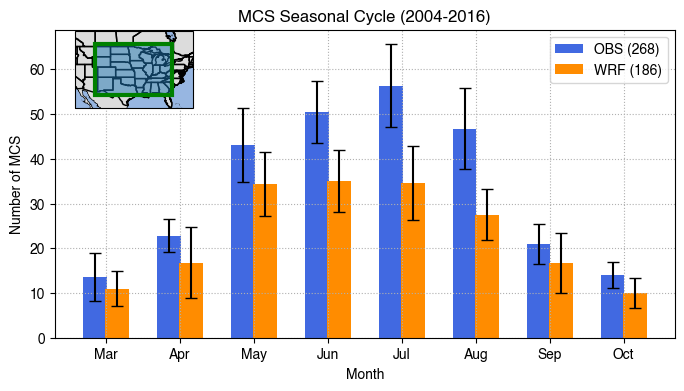

In [14]:
mpl.rcParams['font.family'] = 'Helvetica'
mpl.rcParams['font.weight'] = 'regular'
fig = plt.figure(figsize=[8,4], dpi=100)
ax = plt.subplot()
width = 0.32
ax.bar(np.array(months)-0.15, nmcs_month_avg_obs, width, color='royalblue', yerr=nmcs_month_std_obs, capsize=4, label=f'OBS ({np.sum(nmcs_month_avg_obs):.0f})')
ax.bar(np.array(months)+0.15, nmcs_month_avg_m1, width, color='darkorange', yerr=nmcs_month_std_m1, capsize=4, label=f'WRF ({np.sum(nmcs_month_avg_m1):.0f})')

ax.legend()
ax.set_xlabel('Month', fontweight='regular')
ax.set_ylabel('Number of MCS', fontweight='regular')
ax.set_title(f'MCS Seasonal Cycle ({min(years)}-{max(years)})', fontweight='regular')
ax.grid(True, which='major', ls='dotted')
# ax.set_ylim(0,80)
# ax.set_yticks(np.arange(0,36,5))
ax.set_xticks(months)
ax.set_xticklabels(get_month_names(months))

# Inset map settings
map_extent = [lon_bounds[0]-8,lon_bounds[1]+8,lat_bounds[0]-5,lat_bounds[1]+5]
lonbox = [lon_bounds[0], lon_bounds[1]-1]
latbox = [lat_bounds[0], lat_bounds[1]]
inset_param = {'width':'25%', 'height':'25%', 'loc':'upper left', 'borderpad':0.1}
map_extent, lonbox, latbox

resolution = '50m'
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', resolution)
proj = ccrs.PlateCarree(central_longitude=0)
box_proj = ccrs.PlateCarree(central_longitude=0)
sub_ax = inset_axes(ax, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                    axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                    axes_kwargs=dict(projection=proj))
sub_ax.set_extent(map_extent, box_proj)
# Add land, coastlines, borders to inset
sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
sub_ax.add_feature(states, edgecolor='k', facecolor='none', zorder=4)
# Define the vertices of the rectangle in the projection coordinates
x1, y1 = proj.transform_point(lon_bounds[0], lat_bounds[0], proj)
x2, y2 = proj.transform_point(lon_bounds[1], lat_bounds[1], proj)
# Plot rectangle
sub_ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill=None, lw=3, edgecolor='g', zorder=10))
sub_ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill='g', edgecolor=None, alpha=0.5, zorder=9))

figname = f'{figdir}mcs_number_bymonth_obs_wrf.png'
fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
print(figname)

## Separate land vs. ocean MCS

In [15]:
# Separate land vs. ocean MCS
ds_l_obs, ds_o_obs = get_land_ocean_ds(dsobs, mcsidx_obs, land_frac_thresh, ocean_frac_thresh)
ds_l_obs = dsobs
print(f"Number of land MCS (OBS): {ds_l_obs.dims['tracks']}")
#print(f"Number of land MCS (OBS): {ds_l_obs.dims['tracks']}, Number of ocean MCS (OBS): {ds_o_obs.dims['tracks']}")

# Separate land vs. ocean MCS
ds_l_m1, ds_o_m1 = get_land_ocean_ds(dsm1, mcsidx_m1, land_frac_thresh, ocean_frac_thresh)
ds_l_m1 = dsm1
print(f"Number of land MCS (WRF): {ds_l_m1.dims['tracks']}")
#print(f"Number of land MCS (WRF): {ds_l_m1.dims['tracks']}, Number of ocean MCS (WRF): {ds_o_m1.dims['tracks']}")

Number of land MCS (OBS): 5674
Number of land MCS (WRF): 7162


## Find merge/split track indices

In [16]:
#tid_o_obs = find_merge_split_tracks(ds_o_obs)
tid_l_obs = find_merge_split_tracks(ds_l_obs)

#tid_o_m1 = find_merge_split_tracks(ds_o_m1)
tid_l_m1 = find_merge_split_tracks(ds_l_m1)

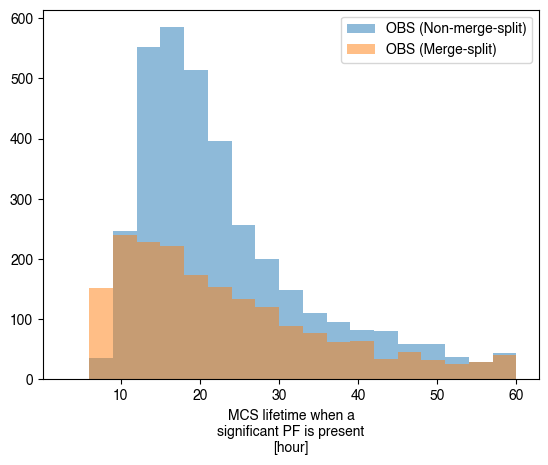

In [17]:
bins = np.arange(3,60.1,3)
ds_l_obs.isel(tracks=tid_l_obs['nms']).pf_lifetime.plot.hist(bins=bins, alpha=0.5, label='OBS (Non-merge-split)')
ds_l_obs.isel(tracks=tid_l_obs['ms']).pf_lifetime.plot.hist(bins=bins, alpha=0.5, label='OBS (Merge-split)')
plt.legend()

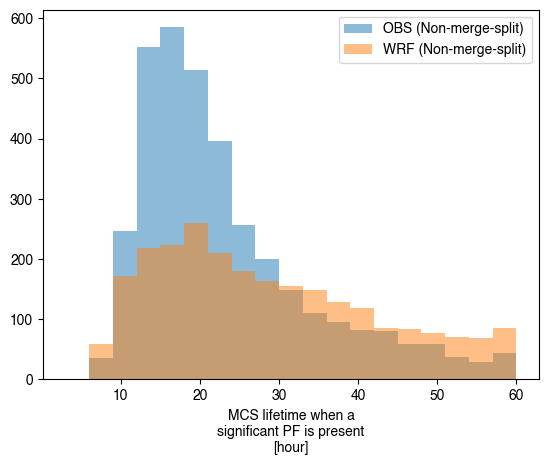

In [18]:
bins = np.arange(3,60.1,3)
ds_l_obs.isel(tracks=tid_l_obs['nms']).pf_lifetime.plot.hist(bins=bins, alpha=0.5, label='OBS (Non-merge-split)')
ds_l_m1.isel(tracks=tid_l_m1['nms']).pf_lifetime.plot.hist(bins=bins, alpha=0.5, label='WRF (Non-merge-split)')
plt.legend()

In [19]:
ds_l_obs.where(ds_l_obs.start_basetime.dt.season == 'JJA', drop=True)

<xarray.Dataset>
Dimensions:                  (tracks: 3250, times: 300, mergers: 200, nmaxpf: 5)
Coordinates:
  * tracks                   (tracks) int64 106 107 108 109 ... 5599 5600 5601
  * times                    (times) int64 0 1 2 3 4 5 ... 295 296 297 298 299
  * mergers                  (mergers) int64 0 1 2 3 4 5 ... 195 196 197 198 199
  * nmaxpf                   (nmaxpf) int64 0 1 2 3 4
Data variables: (12/60)
    track_duration           (tracks) float64 9.0 9.0 5.0 9.0 ... 16.0 8.0 25.0
    start_status             (tracks) float64 1.0 13.0 33.0 ... 46.0 1.0 44.0
    end_status               (tracks) float64 3.0 0.0 0.0 3.0 ... 3.0 0.0 3.0
    start_basetime           (tracks) datetime64[ns] 2004-06-01T21:00:00 ... ...
    end_basetime             (tracks) datetime64[ns] 2004-06-02T21:00:00 ... ...
    start_split_cloudnumber  (tracks) float64 nan nan 1.0 nan ... 1.0 nan 1.0
    ...                       ...
    pf_mcsstatus             (tracks, times) float64 1.0 1.0 1.0 ... nan nan nan
    movement_distance        (tracks, times) float32 145.0 113.2 ... nan nan
    movement_speed           (tracks, times) float32 13.43 10.48 ... nan nan
    movement_theta           (tracks, times) float32 65.56 -32.01 ... nan nan
    movement_distance_x      (tracks, times) float32 60.0 96.0 204.0 ... nan nan
    movement_distance_y      (tracks, times) float32 132.0 -60.0 ... nan nan
Attributes: (12/23)
    Title:                       Statistics of each MCS track
    Institution:                 Pacific Northwest National Laboratory
    Contact:                     Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                  Mon May 15 23:04:35 2023
    startdate:                   20040301.0000
    enddate:                     20041101.0000
    ...                          ...
    PF_PF_min_majoraxis_thresh:  50
    coefs_pf_area:               [2000.    0.]
    coefs_pf_rr:                 [1.5 0. ]
    coefs_pf_skew:               [0.3 0. ]
    coefs_pf_heavyratio:         [0 0]
    max_speed_thresh:            50

## Subset merge/split tracks

In [20]:
#ds_nms_o_obs = ds_o_obs.isel(tracks=tid_o_obs['nms'])
ds_nms_l_obs = ds_l_obs.isel(tracks=tid_l_obs['nms'])
#ds_ms_o_obs = ds_o_obs.isel(tracks=tid_o_obs['ms'])
ds_ms_l_obs = ds_l_obs.isel(tracks=tid_l_obs['ms'])
print(f"Number of non-merge-split tracks OBS (Land): {ds_nms_l_obs.dims['tracks']}")
#print(f"Number of non-merge-split tracks OBS (Ocean): {ds_nms_o_obs.dims['tracks']}")
print(f"Number of merge-split tracks OBS (Land): {ds_ms_l_obs.dims['tracks']}")
#print(f"Number of merge-split tracks OBS (Ocean): {ds_ms_o_obs.dims['tracks']}")

Number of non-merge-split tracks OBS (Land): 3668
Number of merge-split tracks OBS (Land): 2006


In [21]:
#ds_nms_o_m1 = ds_o_m1.isel(tracks=tid_o_m1['nms'])
ds_nms_l_m1 = ds_l_m1.isel(tracks=tid_l_m1['nms'])
#ds_ms_o_m1 = ds_o_m1.isel(tracks=tid_o_m1['ms'])
ds_ms_l_m1 = ds_l_m1.isel(tracks=tid_l_m1['ms'])
print(f"Number of non-merge-split tracks WRF (Land): {ds_nms_l_m1.dims['tracks']}")
#print(f"Number of non-merge-split tracks WRF (Ocean): {ds_nms_o_m1.dims['tracks']}")
print(f"Number of merge-split tracks WRF (Land): {ds_ms_l_m1.dims['tracks']}")
#print(f"Number of merge-split tracks WRF (Ocean): {ds_ms_o_m1.dims['tracks']}")

Number of non-merge-split tracks WRF (Land): 2846
Number of merge-split tracks WRF (Land): 4316


## Function to compute 1D KDE

In [22]:
def get_kde1d(data, bins, kde_bw, kde_kernel='gaussian'):
    """
    Compute 1D KDE using Ski-learn
    
    Args:
        data: np.array
            Array containing data.
        bins: np.array
            Desired bins for plotting.
        kde_bw: float
            The bandwidth of the kernel.
        kde_kernel: string
            The kernel to use.
            
    Return:
        kde_out: np.array
            KDE at the desired bins.
    """
    # Flatten array to 1D
    data1d = data.flatten()
    # Remove NaN (sklearn KDE does not handle NaN), and make a new axis
    _data = data1d[~np.isnan(data1d)][:, np.newaxis]
    _bins = bins[:, np.newaxis]
    
    # Estimate 1D KDE following sklearn example
    # https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html
    kde = KernelDensity(kernel=kde_kernel, bandwidth=kde_bw).fit(_data)
    # Get KDE values based on input bins
    log_dens = kde.score_samples(_bins)
    # Get linear density
    kde_out = np.exp(log_dens)
    return kde_out

In [23]:
# Get track start season (e.g., MAM, JJA, SON, DJF)
start_season_obs = ds_l_obs.start_basetime.dt.season
start_season_m1 = ds_l_m1.start_basetime.dt.season

### CCS Lifetime

In [24]:
time_res_obs, time_res_m1

(3.0, 3.0)

In [25]:
lifetime_bins = np.linspace(0, 60, 1000)
# Get CCS lifetime by season
ccslifetime_nms_l_obs_MAM = (ds_nms_l_obs.track_duration.where(start_season_obs == 'MAM', drop=True) * time_res_obs)
ccslifetime_nms_l_m1_MAM = (ds_nms_l_m1.track_duration.where(start_season_m1 == 'MAM', drop=True) * time_res_m1)
ccslifetime_nms_l_obs_JJA = (ds_nms_l_obs.track_duration.where(start_season_obs == 'JJA', drop=True) * time_res_obs)
ccslifetime_nms_l_m1_JJA = (ds_nms_l_m1.track_duration.where(start_season_m1 == 'JJA', drop=True) * time_res_m1)
# By season
kde_ccslifetime_nms_l_obs_MAM = get_kde1d(ccslifetime_nms_l_obs_MAM.data, lifetime_bins, kde_bw=3)
kde_ccslifetime_nms_l_m1_MAM = get_kde1d(ccslifetime_nms_l_m1_MAM.data, lifetime_bins, kde_bw=3)
kde_ccslifetime_nms_l_obs_JJA = get_kde1d(ccslifetime_nms_l_obs_JJA.data, lifetime_bins, kde_bw=3)
kde_ccslifetime_nms_l_m1_JJA = get_kde1d(ccslifetime_nms_l_m1_JJA.data, lifetime_bins, kde_bw=3)

# All season
kde_ccslifetime_nms_l_obs = get_kde1d((ds_nms_l_obs.track_duration * time_res_obs).data, lifetime_bins, kde_bw=3)
kde_ccslifetime_nms_l_m1 = get_kde1d((ds_nms_l_m1.track_duration * time_res_m1).data, lifetime_bins, kde_bw=3)

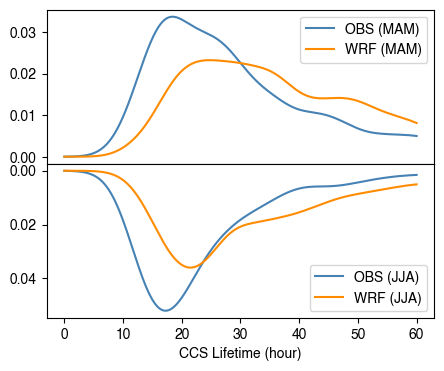

In [26]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(lifetime_bins, kde_ccslifetime_nms_l_obs_MAM, 'steelblue', label='OBS (MAM)')
ax.plot(lifetime_bins, kde_ccslifetime_nms_l_m1_MAM, 'darkorange', label='WRF (MAM)')
ax.legend()
ax = axes[1]
ax.plot(lifetime_bins, kde_ccslifetime_nms_l_obs_JJA, 'steelblue', label='OBS (JJA)')
ax.plot(lifetime_bins, kde_ccslifetime_nms_l_m1_JJA, 'darkorange', label='WRF (JJA)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('CCS Lifetime (hour)')
fig.subplots_adjust(hspace=0)

### PF Lifetime

In [27]:
# Get PF lifetime by season
pflifetime_nms_l_obs_MAM = (ds_nms_l_obs.pf_lifetime.where(start_season_obs == 'MAM', drop=True))
pflifetime_nms_l_m1_MAM = (ds_nms_l_m1.pf_lifetime.where(start_season_m1 == 'MAM', drop=True))
pflifetime_nms_l_obs_JJA = (ds_nms_l_obs.pf_lifetime.where(start_season_obs == 'JJA', drop=True))
pflifetime_nms_l_m1_JJA = (ds_nms_l_m1.pf_lifetime.where(start_season_m1 == 'JJA', drop=True))
# By season
kde_pflifetime_nms_l_obs_MAM = get_kde1d(pflifetime_nms_l_obs_MAM.data, lifetime_bins, kde_bw=3)
kde_pflifetime_nms_l_m1_MAM = get_kde1d(pflifetime_nms_l_m1_MAM.data, lifetime_bins, kde_bw=3)
kde_pflifetime_nms_l_obs_JJA = get_kde1d(pflifetime_nms_l_obs_JJA.data, lifetime_bins, kde_bw=3)
kde_pflifetime_nms_l_m1_JJA = get_kde1d(pflifetime_nms_l_m1_JJA.data, lifetime_bins, kde_bw=3)

# All season
kde_pflifetime_nms_l_obs = get_kde1d(ds_nms_l_obs.pf_lifetime.data, lifetime_bins, kde_bw=3)
kde_pflifetime_nms_l_m1 = get_kde1d(ds_nms_l_m1.pf_lifetime.data, lifetime_bins, kde_bw=3)

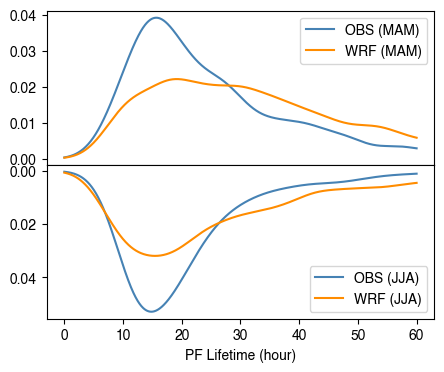

In [28]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(lifetime_bins, kde_pflifetime_nms_l_obs_MAM, 'steelblue', label='OBS (MAM)')
ax.plot(lifetime_bins, kde_pflifetime_nms_l_m1_MAM, 'darkorange', label='WRF (MAM)')
ax.legend()
ax = axes[1]
ax.plot(lifetime_bins, kde_pflifetime_nms_l_obs_JJA, 'steelblue', label='OBS (JJA)')
ax.plot(lifetime_bins, kde_pflifetime_nms_l_m1_JJA, 'darkorange', label='WRF (JJA)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('PF Lifetime (hour)')
fig.subplots_adjust(hspace=0)

### Max CCS Area

In [29]:
ccsarea_bins = np.linspace(4, 6.8, 1000)
# Add mergers/splits to get total CCS area
ccsarea_l_obs = ds_nms_l_obs.ccs_area + ds_nms_l_obs.merge_ccs_area.sum(dim='mergers') + ds_nms_l_obs.split_ccs_area.sum(dim='mergers')
maxccsarea_l_obs = ccsarea_l_obs.max(dim='times')
ccsarea_l_m1 = ds_nms_l_m1.ccs_area + ds_nms_l_m1.merge_ccs_area.sum(dim='mergers') + ds_nms_l_m1.split_ccs_area.sum(dim='mergers')
maxccsarea_l_m1 = ccsarea_l_m1.max(dim='times')
# By season
maxccsarea_l_obs_MAM = maxccsarea_l_obs.where(start_season_obs == 'MAM', drop=True)
maxccsarea_l_m1_MAM = maxccsarea_l_m1.where(start_season_m1 == 'MAM', drop=True)
maxccsarea_l_obs_JJA = maxccsarea_l_obs.where(start_season_obs == 'JJA', drop=True)
maxccsarea_l_m1_JJA = maxccsarea_l_m1.where(start_season_m1 == 'JJA', drop=True)

kde_maxccsarea_nms_l_obs_MAM = get_kde1d(np.log10(maxccsarea_l_obs_MAM.data), ccsarea_bins, kde_bw=0.2)
kde_maxccsarea_nms_l_m1_MAM = get_kde1d(np.log10(maxccsarea_l_m1_MAM.data), ccsarea_bins, kde_bw=0.2)
kde_maxccsarea_nms_l_obs_JJA = get_kde1d(np.log10(maxccsarea_l_obs_JJA.data), ccsarea_bins, kde_bw=0.2)
kde_maxccsarea_nms_l_m1_JJA = get_kde1d(np.log10(maxccsarea_l_m1_JJA.data), ccsarea_bins, kde_bw=0.2)

# All season
kde_maxccsarea_nms_l_obs = get_kde1d(np.log10(maxccsarea_l_obs.data), ccsarea_bins, kde_bw=0.2)
kde_maxccsarea_nms_l_m1 = get_kde1d(np.log10(maxccsarea_l_m1.data), ccsarea_bins, kde_bw=0.2)

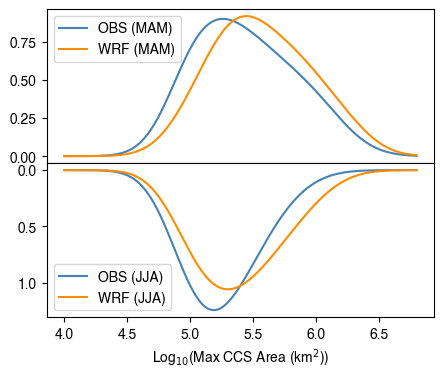

In [30]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(ccsarea_bins, kde_maxccsarea_nms_l_obs_MAM, 'steelblue', label='OBS (MAM)')
ax.plot(ccsarea_bins, kde_maxccsarea_nms_l_m1_MAM, 'darkorange', label='WRF (MAM)')
ax.legend()
ax = axes[1]
ax.plot(ccsarea_bins, kde_maxccsarea_nms_l_obs_JJA, 'steelblue', label='OBS (JJA)')
ax.plot(ccsarea_bins, kde_maxccsarea_nms_l_m1_JJA, 'darkorange', label='WRF (JJA)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('Log$_{10}$(Max CCS Area (km$^2$))')
fig.subplots_adjust(hspace=0)

### Lifetime-average min Tb

In [31]:
avgmintb_bins = np.linspace(200, 240, 1000)
# By season
kde_avgmintb_nms_l_obs_MAM = get_kde1d(ds_nms_l_obs.corecold_mintb.where(start_season_obs == 'MAM', drop=True).mean(dim='times').data, avgmintb_bins, kde_bw=2)
kde_avgmintb_nms_l_m1_MAM = get_kde1d(ds_nms_l_m1.corecold_mintb.where(start_season_m1 == 'MAM', drop=True).mean(dim='times').data, avgmintb_bins, kde_bw=2)
kde_avgmintb_nms_l_obs_JJA = get_kde1d(ds_nms_l_obs.corecold_mintb.where(start_season_obs == 'JJA', drop=True).mean(dim='times').data, avgmintb_bins, kde_bw=2)
kde_avgmintb_nms_l_m1_JJA = get_kde1d(ds_nms_l_m1.corecold_mintb.where(start_season_m1 == 'JJA', drop=True).mean(dim='times').data, avgmintb_bins, kde_bw=2)

# Land
kde_avgmintb_nms_l_obs = get_kde1d(ds_nms_l_obs.corecold_mintb.mean(dim='times').data, avgmintb_bins, kde_bw=2)
kde_avgmintb_nms_l_m1 = get_kde1d(ds_nms_l_m1.corecold_mintb.mean(dim='times').data, avgmintb_bins, kde_bw=2)

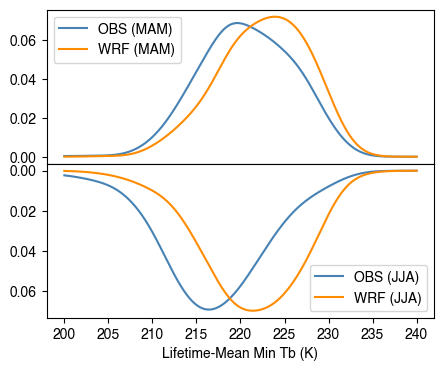

In [32]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(avgmintb_bins, kde_avgmintb_nms_l_obs_MAM, 'steelblue', label='OBS (MAM)')
ax.plot(avgmintb_bins, kde_avgmintb_nms_l_m1_MAM, 'darkorange', label='WRF (MAM)')
ax.legend()
ax = axes[1]
ax.plot(avgmintb_bins, kde_avgmintb_nms_l_obs_JJA, 'steelblue', label='OBS (JJA)')
ax.plot(avgmintb_bins, kde_avgmintb_nms_l_m1_JJA, 'darkorange', label='WRF (JJA)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('Lifetime-Mean Min Tb (K)')
fig.subplots_adjust(hspace=0)

### Lifetime-min Min Tb

In [33]:
mintb_bins = np.linspace(190, 230, 1000)
# By season
kde_mintb_nms_l_obs_MAM = get_kde1d(ds_nms_l_obs.corecold_mintb.where(start_season_obs == 'MAM', drop=True).min(dim='times').data, mintb_bins, kde_bw=2)
kde_mintb_nms_l_m1_MAM = get_kde1d(ds_nms_l_m1.corecold_mintb.where(start_season_m1 == 'MAM', drop=True).min(dim='times').data, mintb_bins, kde_bw=2)
kde_mintb_nms_l_obs_JJA = get_kde1d(ds_nms_l_obs.corecold_mintb.where(start_season_obs == 'JJA', drop=True).min(dim='times').data, mintb_bins, kde_bw=2)
kde_mintb_nms_l_m1_JJA = get_kde1d(ds_nms_l_m1.corecold_mintb.where(start_season_m1 == 'JJA', drop=True).min(dim='times').data, mintb_bins, kde_bw=2)

# All seasons
kde_mintb_nms_l_obs = get_kde1d(ds_nms_l_obs.corecold_mintb.min(dim='times').data, mintb_bins, kde_bw=2)
kde_mintb_nms_l_m1 = get_kde1d(ds_nms_l_m1.corecold_mintb.min(dim='times').data, mintb_bins, kde_bw=2)

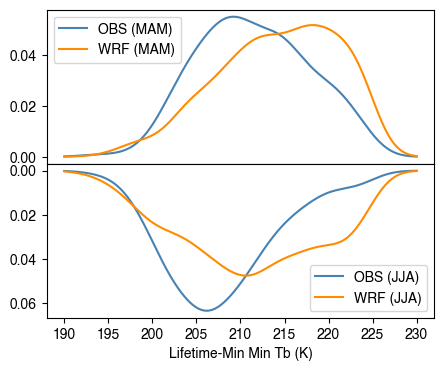

In [34]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(mintb_bins, kde_mintb_nms_l_obs_MAM, 'steelblue', label='OBS (MAM)')
ax.plot(mintb_bins, kde_mintb_nms_l_m1_MAM, 'darkorange', label='WRF (MAM)')
ax.legend()
ax = axes[1]
ax.plot(mintb_bins, kde_mintb_nms_l_obs_JJA, 'steelblue', label='OBS (JJA)')
ax.plot(mintb_bins, kde_mintb_nms_l_m1_JJA, 'darkorange', label='WRF (JJA)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('Lifetime-Min Min Tb (K)')
fig.subplots_adjust(hspace=0)

### Max PF Area

In [35]:
pfarea_bins = np.linspace(3.3, 6.5, 1000)
# Sum all PFs at a given time, then take max during lifetime
# Land
maxpfarea_l_obs = ds_nms_l_obs.pf_area.sum(dim='nmaxpf').max(dim='times')
maxpfarea_l_m1 = ds_nms_l_m1.pf_area.sum(dim='nmaxpf').max(dim='times')
# maxpfarea_l_obs = ds_nms_l_obs.pf_area.max(dim='nmaxpf').max(dim='times')
# maxpfarea_l_m1 = ds_nms_l_m1.pf_area.max(dim='nmaxpf').max(dim='times')
# By season
kde_maxpfarea_nms_l_obs_MAM = get_kde1d(np.log10(maxpfarea_l_obs.where(start_season_obs == 'MAM', drop=True).data), pfarea_bins, kde_bw=0.2)
kde_maxpfarea_nms_l_m1_MAM = get_kde1d(np.log10(maxpfarea_l_m1.where(start_season_obs == 'MAM', drop=True).data), pfarea_bins, kde_bw=0.2)
kde_maxpfarea_nms_l_obs_JJA = get_kde1d(np.log10(maxpfarea_l_obs.where(start_season_obs == 'JJA', drop=True).data), pfarea_bins, kde_bw=0.2)
kde_maxpfarea_nms_l_m1_JJA = get_kde1d(np.log10(maxpfarea_l_m1.where(start_season_obs == 'JJA', drop=True).data), pfarea_bins, kde_bw=0.2)

# All seasons
kde_maxpfarea_nms_l_obs = get_kde1d(np.log10(maxpfarea_l_obs.data), pfarea_bins, kde_bw=0.2)
kde_maxpfarea_nms_l_m1 = get_kde1d(np.log10(maxpfarea_l_m1.data), pfarea_bins, kde_bw=0.2)

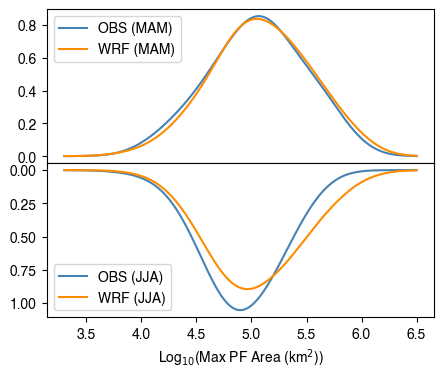

In [36]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(pfarea_bins, kde_maxpfarea_nms_l_obs_MAM, 'steelblue', label='OBS (MAM)')
ax.plot(pfarea_bins, kde_maxpfarea_nms_l_m1_MAM, 'darkorange', label='WRF (MAM)')
ax.legend()
ax = axes[1]
ax.plot(pfarea_bins, kde_maxpfarea_nms_l_obs_JJA, 'steelblue', label='OBS (JJA)')
ax.plot(pfarea_bins, kde_maxpfarea_nms_l_m1_JJA, 'darkorange', label='WRF (JJA)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('Log$_{10}$(Max PF Area (km$^2$))')
fig.subplots_adjust(hspace=0)

### Mean PF Rain Rate

In [37]:
pfrainrate_bins = np.linspace(0., 5, 1000)
# Select the largest PF (nmaxpf=0), then take mean during lifetime
# By season
kde_meanpfrainrate_nms_l_obs_MAM = get_kde1d(ds_nms_l_obs.pf_rainrate.isel(nmaxpf=0).where(start_season_obs == 'MAM', drop=True).mean(dim='times').data, pfrainrate_bins, kde_bw=0.25)
kde_meanpfrainrate_nms_l_m1_MAM = get_kde1d(ds_nms_l_m1.pf_rainrate.isel(nmaxpf=0).where(start_season_obs == 'MAM', drop=True).mean(dim='times').data, pfrainrate_bins, kde_bw=0.25)
kde_meanpfrainrate_nms_l_obs_JJA = get_kde1d(ds_nms_l_obs.pf_rainrate.isel(nmaxpf=0).where(start_season_obs == 'JJA', drop=True).mean(dim='times').data, pfrainrate_bins, kde_bw=0.25)
kde_meanpfrainrate_nms_l_m1_JJA = get_kde1d(ds_nms_l_m1.pf_rainrate.isel(nmaxpf=0).where(start_season_obs == 'JJA', drop=True).mean(dim='times').data, pfrainrate_bins, kde_bw=0.25)

# Land
kde_meanpfrainrate_nms_l_obs = get_kde1d(ds_nms_l_obs.pf_rainrate.isel(nmaxpf=0).mean(dim='times').data, pfrainrate_bins, kde_bw=0.5)
kde_meanpfrainrate_nms_l_m1 = get_kde1d(ds_nms_l_m1.pf_rainrate.isel(nmaxpf=0).mean(dim='times').data, pfrainrate_bins, kde_bw=0.5)

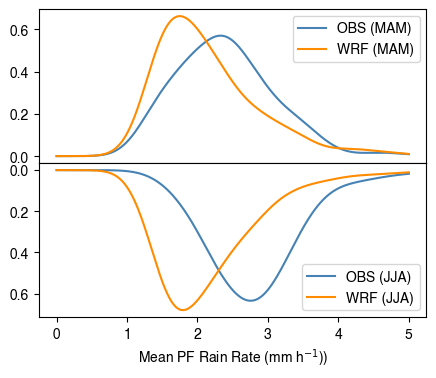

In [38]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(pfrainrate_bins, kde_meanpfrainrate_nms_l_obs_MAM, 'steelblue', label='OBS (MAM)')
ax.plot(pfrainrate_bins, kde_meanpfrainrate_nms_l_m1_MAM, 'darkorange', label='WRF (MAM)')
ax.legend()
ax = axes[1]
ax.plot(pfrainrate_bins, kde_meanpfrainrate_nms_l_obs_JJA, 'steelblue', label='OBS (JJA)')
ax.plot(pfrainrate_bins, kde_meanpfrainrate_nms_l_m1_JJA, 'darkorange', label='WRF (JJA)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('Mean PF Rain Rate (mm h$^{-1}$))')
fig.subplots_adjust(hspace=0)

### Lifetime-total Rain Volume

In [39]:
volrain_bins = np.linspace(4.5, 8.0, 1000)

# Lifetime total rain volume [unit: kg]
pfvolrain_l_obs = ds_nms_l_obs.total_rain.sum(dim='times') * pixel_radius_obs**2
pfvolrain_l_m1 = ds_nms_l_m1.total_rain.sum(dim='times') * pixel_radius_m1**2
# By season
kde_pfvolrain_nms_l_obs_MAM = get_kde1d(np.log10(pfvolrain_l_obs.where(start_season_obs == 'MAM', drop=True).data), volrain_bins, kde_bw=0.2)
kde_pfvolrain_nms_l_m1_MAM = get_kde1d(np.log10(pfvolrain_l_m1.where(start_season_m1 == 'MAM', drop=True).data), volrain_bins, kde_bw=0.2)
kde_pfvolrain_nms_l_obs_JJA = get_kde1d(np.log10(pfvolrain_l_obs.where(start_season_obs == 'JJA', drop=True).data), volrain_bins, kde_bw=0.2)
kde_pfvolrain_nms_l_m1_JJA = get_kde1d(np.log10(pfvolrain_l_m1.where(start_season_m1 == 'JJA', drop=True).data), volrain_bins, kde_bw=0.2)

# All seasons
kde_pfvolrain_nms_l_obs = get_kde1d(np.log10(pfvolrain_l_obs.data), volrain_bins, kde_bw=0.2)
kde_pfvolrain_nms_l_m1 = get_kde1d(np.log10(pfvolrain_l_m1.data), volrain_bins, kde_bw=0.2)

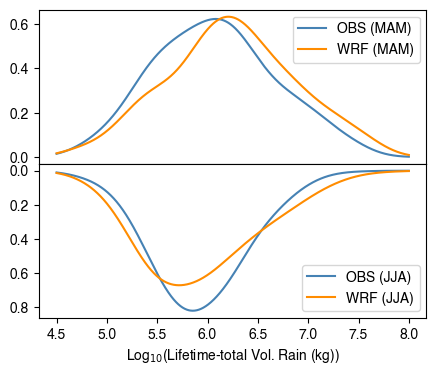

In [40]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(volrain_bins, kde_pfvolrain_nms_l_obs_MAM, 'steelblue', label='OBS (MAM)')
ax.plot(volrain_bins, kde_pfvolrain_nms_l_m1_MAM, 'darkorange', label='WRF (MAM)')
ax.legend()
ax = axes[1]
ax.plot(volrain_bins, kde_pfvolrain_nms_l_obs_JJA, 'steelblue', label='OBS (JJA)')
ax.plot(volrain_bins, kde_pfvolrain_nms_l_m1_JJA, 'darkorange', label='WRF (JJA)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('Log$_{10}$(Lifetime-total Vol. Rain (kg))')
fig.subplots_adjust(hspace=0)

### Heavy rain volume

In [41]:
# Lifetime total heavy rain volume [unit: kg]
# Land
pfheavyvolrain_l_obs = ds_nms_l_obs.total_heavyrain.sum(dim='times') * pixel_radius_obs**2
pfheavyvolrain_l_m1 = ds_nms_l_m1.total_heavyrain.sum(dim='times') * pixel_radius_m1**2

heavyvolrain_bins = np.linspace(4, 8, 1000)
# By seasons
kde_pfheavyvolrain_nms_l_obs_MAM = get_kde1d(np.log10(pfheavyvolrain_l_obs.where(start_season_obs == 'MAM', drop=True).data), heavyvolrain_bins, kde_bw=0.2)
kde_pfheavyvolrain_nms_l_m1_MAM = get_kde1d(np.log10(pfheavyvolrain_l_m1.where(start_season_obs == 'MAM', drop=True).data), heavyvolrain_bins, kde_bw=0.2)
kde_pfheavyvolrain_nms_l_obs_JJA = get_kde1d(np.log10(pfheavyvolrain_l_obs.where(start_season_obs == 'JJA', drop=True).data), heavyvolrain_bins, kde_bw=0.2)
kde_pfheavyvolrain_nms_l_m1_JJA = get_kde1d(np.log10(pfheavyvolrain_l_m1.where(start_season_obs == 'JJA', drop=True).data), heavyvolrain_bins, kde_bw=0.2)

# All seasons
kde_pfheavyvolrain_nms_l_obs = get_kde1d(np.log10(pfheavyvolrain_l_obs.data), heavyvolrain_bins, kde_bw=0.2)
kde_pfheavyvolrain_nms_l_m1 = get_kde1d(np.log10(pfheavyvolrain_l_m1.data), heavyvolrain_bins, kde_bw=0.2)

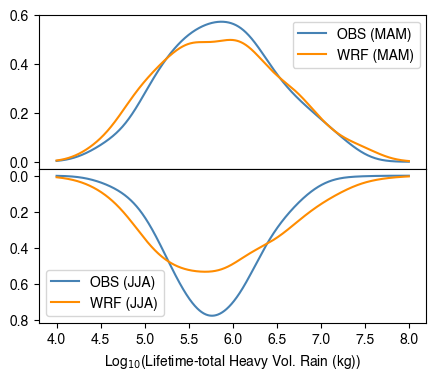

In [42]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(heavyvolrain_bins, kde_pfheavyvolrain_nms_l_obs_MAM, 'steelblue', label='OBS (MAM)')
ax.plot(heavyvolrain_bins, kde_pfheavyvolrain_nms_l_m1_MAM, 'darkorange', label='WRF (MAM)')
ax.legend()
ax = axes[1]
ax.plot(heavyvolrain_bins, kde_pfheavyvolrain_nms_l_obs_JJA, 'steelblue', label='OBS (JJA)')
ax.plot(heavyvolrain_bins, kde_pfheavyvolrain_nms_l_m1_JJA, 'darkorange', label='WRF (JJA)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('Log$_{10}$(Lifetime-total Heavy Vol. Rain (kg))')
fig.subplots_adjust(hspace=0)

### Heavy Rain Volume Ratio

In [43]:
# Heavy rain volume ratio (heavy rain vol. / total rain vol.)
pfhrr_nms_l_obs = 100 * pfheavyvolrain_l_obs / pfvolrain_l_obs
pfhrr_nms_l_m1 = 100 * pfheavyvolrain_l_m1 / pfvolrain_l_m1

pfhrr_bins = np.linspace(0, 100, 1000)
# By season
kde_pfhrr_nms_l_obs_MAM = get_kde1d(pfhrr_nms_l_obs.where(start_season_obs == 'MAM', drop=True).data, pfhrr_bins, kde_bw=4)
kde_pfhrr_nms_l_m1_MAM = get_kde1d(pfhrr_nms_l_m1.where(start_season_obs == 'MAM', drop=True).data, pfhrr_bins, kde_bw=4)
kde_pfhrr_nms_l_obs_JJA = get_kde1d(pfhrr_nms_l_obs.where(start_season_obs == 'JJA', drop=True).data, pfhrr_bins, kde_bw=4)
kde_pfhrr_nms_l_m1_JJA = get_kde1d(pfhrr_nms_l_m1.where(start_season_obs == 'JJA', drop=True).data, pfhrr_bins, kde_bw=4)

# All seasons
kde_pfhrr_nms_l_obs = get_kde1d(pfhrr_nms_l_obs.data, pfhrr_bins, kde_bw=4)
kde_pfhrr_nms_l_m1 = get_kde1d(pfhrr_nms_l_m1.data, pfhrr_bins, kde_bw=4)

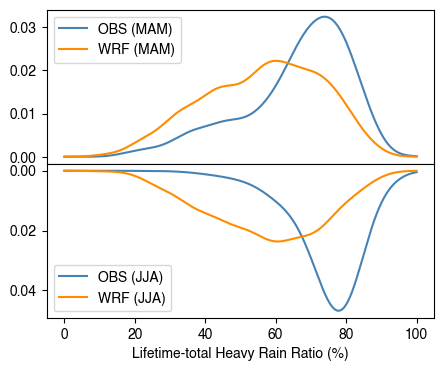

In [44]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(pfhrr_bins, kde_pfhrr_nms_l_obs_MAM, 'steelblue', label='OBS (MAM)')
ax.plot(pfhrr_bins, kde_pfhrr_nms_l_m1_MAM, 'darkorange', label='WRF (MAM)')
ax.legend()
ax = axes[1]
ax.plot(pfhrr_bins, kde_pfhrr_nms_l_obs_JJA, 'steelblue', label='OBS (JJA)')
ax.plot(pfhrr_bins, kde_pfhrr_nms_l_m1_JJA, 'darkorange', label='WRF (JJA)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('Lifetime-total Heavy Rain Ratio (%)')
fig.subplots_adjust(hspace=0)

### MCS Lifetime-median PF Movement Speed

In [45]:
# PF movement speed
pfspeed_bins = np.linspace(0, 25, 1000)
# By season
kde_pfspeed_nms_l_obs_MAM = get_kde1d(ds_nms_l_obs.movement_speed.where(start_season_obs == 'MAM', drop=True).median(dim='times').data, pfspeed_bins, kde_bw=2)
kde_pfspeed_nms_l_m1_MAM = get_kde1d(ds_nms_l_m1.movement_speed.where(start_season_obs == 'MAM', drop=True).median(dim='times').data, pfspeed_bins, kde_bw=2)
kde_pfspeed_nms_l_obs_JJA = get_kde1d(ds_nms_l_obs.movement_speed.where(start_season_obs == 'JJA', drop=True).median(dim='times').data, pfspeed_bins, kde_bw=2)
kde_pfspeed_nms_l_m1_JJA = get_kde1d(ds_nms_l_m1.movement_speed.where(start_season_obs == 'JJA', drop=True).median(dim='times').data, pfspeed_bins, kde_bw=2)

# All seasons
kde_pfspeed_nms_l_obs = get_kde1d(ds_nms_l_obs.movement_speed.median(dim='times').data, pfspeed_bins, kde_bw=2)
kde_pfspeed_nms_l_m1 = get_kde1d(ds_nms_l_m1.movement_speed.median(dim='times').data, pfspeed_bins, kde_bw=2)

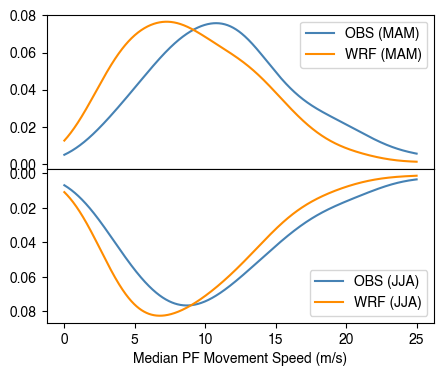

In [46]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(pfspeed_bins, kde_pfspeed_nms_l_obs_MAM, 'steelblue', label='OBS (MAM)')
ax.plot(pfspeed_bins, kde_pfspeed_nms_l_m1_MAM, 'darkorange', label='WRF (MAM)')
ax.legend()
ax = axes[1]
ax.plot(pfspeed_bins, kde_pfspeed_nms_l_obs_JJA, 'steelblue', label='OBS (JJA)')
ax.plot(pfspeed_bins, kde_pfspeed_nms_l_m1_JJA, 'darkorange', label='WRF (JJA)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('Median PF Movement Speed (m/s)')
fig.subplots_adjust(hspace=0)

## Put variables into dictionary for plotting

In [47]:
# MAM variables
ccslifetime_dict_MAM = {
    'obs': kde_ccslifetime_nms_l_obs_MAM,
    'm1': kde_ccslifetime_nms_l_m1_MAM,
}
pfspeed_dict_MAM = {
    'obs': kde_pfspeed_nms_l_obs_MAM,
    'm1': kde_pfspeed_nms_l_m1_MAM,
}
ccsarea_dict_MAM = {
    'obs': kde_maxccsarea_nms_l_obs_MAM,
    'm1': kde_maxccsarea_nms_l_m1_MAM,
}
mintb_dict_MAM = {
    'obs': kde_avgmintb_nms_l_obs_MAM,
    'm1': kde_avgmintb_nms_l_m1_MAM,
}
pfarea_dict_MAM = {
    'obs': kde_maxpfarea_nms_l_obs_MAM,
    'm1': kde_maxpfarea_nms_l_m1_MAM,
}
pfrainrate_dict_MAM = {
    'obs': kde_meanpfrainrate_nms_l_obs_MAM,
    'm1': kde_meanpfrainrate_nms_l_m1_MAM,
}
volrain_dict_MAM = {
    'obs': kde_pfvolrain_nms_l_obs_MAM,
    'm1': kde_pfvolrain_nms_l_m1_MAM,
}
heavyvolrain_dict_MAM = {
    'obs': kde_pfheavyvolrain_nms_l_obs_MAM,
    'm1': kde_pfheavyvolrain_nms_l_m1_MAM,
}
hrr_dict_MAM = {
    'obs': kde_pfhrr_nms_l_obs_MAM,
    'm1': kde_pfhrr_nms_l_m1_MAM,
}

# JJA variables
ccslifetime_dict_JJA = {
   'obs':kde_ccslifetime_nms_l_obs_JJA,
   'm1': kde_ccslifetime_nms_l_m1_JJA,
}
pfspeed_dict_JJA = {
   'obs': kde_pfspeed_nms_l_obs_JJA,
   'm1': kde_pfspeed_nms_l_m1_JJA,
}
ccsarea_dict_JJA = {
   'obs': kde_maxccsarea_nms_l_obs_JJA,
   'm1': kde_maxccsarea_nms_l_m1_JJA,
}
mintb_dict_JJA = {
   'obs': kde_avgmintb_nms_l_obs_JJA,
   'm1': kde_avgmintb_nms_l_m1_JJA,
}
pfarea_dict_JJA = {
   'obs': kde_maxpfarea_nms_l_obs_JJA,
   'm1': kde_maxpfarea_nms_l_m1_JJA,
}
pfrainrate_dict_JJA = {
   'obs': kde_meanpfrainrate_nms_l_obs_JJA,
   'm1': kde_meanpfrainrate_nms_l_m1_JJA,
}
volrain_dict_JJA = {
   'obs': kde_pfvolrain_nms_l_obs_JJA,
   'm1': kde_pfvolrain_nms_l_m1_JJA,
}
heavyvolrain_dict_JJA = {
   'obs': kde_pfheavyvolrain_nms_l_obs_JJA,
   'm1': kde_pfheavyvolrain_nms_l_m1_JJA,
}
hrr_dict_JJA = {
   'obs': kde_pfhrr_nms_l_obs_JJA,
   'm1': kde_pfhrr_nms_l_m1_JJA,
}

## Function to plot mirror 1D KDE on (m row x n column) panels

In [48]:
def plot_pdf_mirror_mxn(nrow, ncol, nrowsub, ncolsub, bins, data_top, data_bot, titles, xlabels, ylabels, legends, figname,  
                map_extent=None, lonbox=None, latbox=None, inset_param=None, map_panel=None,
                xscale=None, yscale=None, xlims=None, ylims=None, label_topbot=None, label_pos=None,
                legend_fontsize=11, legend_loc=None, legend_ncol=None, figsize=None):
    
    mpl.rcParams['font.size'] = 13
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    
    lw = 3
    lcolors = {
        'obs':'steelblue', 
        'm1': 'darkorange',
    }
    
    fig = plt.figure(figsize=figsize, constrained_layout=False, dpi=100)
    outer_grid = fig.add_gridspec(nrow, ncol, wspace=0.25, hspace=0.3)

    for row in range(nrow):
        for col in range(ncol):
            # gridspec inside gridspec
            inner_grid = outer_grid[row, col].subgridspec(nrowsub, ncolsub, wspace=0, hspace=0)
            axs = inner_grid.subplots()
            ax1 = axs[0]  # top
            ax2 = axs[1]  # bottom
            ax2.invert_yaxis()
            # Top panel
            ax1.plot(bins[row][col], data_top[row][col]['obs'], lcolors['obs'], lw=lw, label=legends['obs'])
            ax1.plot(bins[row][col], data_top[row][col]['m1'], lcolors['m1'], lw=lw, label=legends['m1'])
            # Bottom panel
            ax2.plot(bins[row][col], data_bot[row][col]['obs'], lcolors['obs'], lw=lw, label=legends['obs'])
            ax2.plot(bins[row][col], data_bot[row][col]['m1'], lcolors['m1'], lw=lw, label=legends['m1'])
            # Labels, gridlines, etc.
            ax1.grid(which='major', ls='--')
            ax2.grid(which='major', ls='--')
            ax1.set_title(titles[row][col], loc='left')
            ax2.set_xlabel(xlabels[row][col])
            # Hide x axis label marks
            ax1.tick_params(labelbottom=False) 
            # Label top/bottom panels
            ax1.text(label_pos['top']['x'], label_pos['top']['y'], label_topbot['top'], ha='left', transform=ax1.transAxes)
            ax2.text(label_pos['bottom']['x'], label_pos['bottom']['y'], label_topbot['bottom'], ha='left', transform=ax2.transAxes)
            # Label yaxis, legend
            if (col == 0):
                ax1.legend(fontsize=legend_fontsize, loc=legend_loc[0], ncol=legend_ncol[0])
                ax1.text(-0.25, 1, ylabels[row][col], va='center', ha='center', rotation=90, transform=ax2.transAxes)           
            
            # Plot inset map
            if (row == map_panel['row']) & (col == map_panel['col']) & (map_panel['rowsub'] == 0) & (map_panel['colsub'] == 0):
                resolution = '110m'
                land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
                ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
                states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', resolution)
                # proj = ccrs.PlateCarree(central_longitude=180)
                proj = ccrs.PlateCarree(central_longitude=0)
                box_proj = ccrs.PlateCarree(central_longitude=0)
                sub_ax = inset_axes(ax1, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                    axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                    axes_kwargs=dict(projection=proj))
                sub_ax.set_extent(map_extent, box_proj)
                # Add land, coastlines, borders to inset
                sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
                sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
                sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=4)
                sub_ax.add_feature(states, edgecolor='k', facecolor='none', zorder=4)
                # Define the vertices of the rectangle in the projection coordinates
                x1, y1 = proj.transform_point(lon_bounds[0], lat_bounds[0], proj)
                x2, y2 = proj.transform_point(lon_bounds[1], lat_bounds[1], proj)
                # Plot rectangle
                sub_ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill=None, lw=2, edgecolor='g', zorder=10))
                sub_ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill='g', edgecolor=None, alpha=0.6, zorder=10))

    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

## Setup legend, inset map

In [49]:
legends = {
    'obs': 'OBS',
    'm1': 'WRF',
}
# Inset map settings
map_extent = [lon_bounds[0]-5,lon_bounds[1]+5,lat_bounds[0]-3,lat_bounds[1]+3]
lonbox = [lon_bounds[0], lon_bounds[1]-1]
latbox = [lat_bounds[0], lat_bounds[1]]
inset_param = {'width':'40%', 'height':'30%', 'loc':'upper right', 'borderpad':0.1}
map_extent, lonbox, latbox

([-115, -75, 27, 53], [-110, -81], [30, 50])

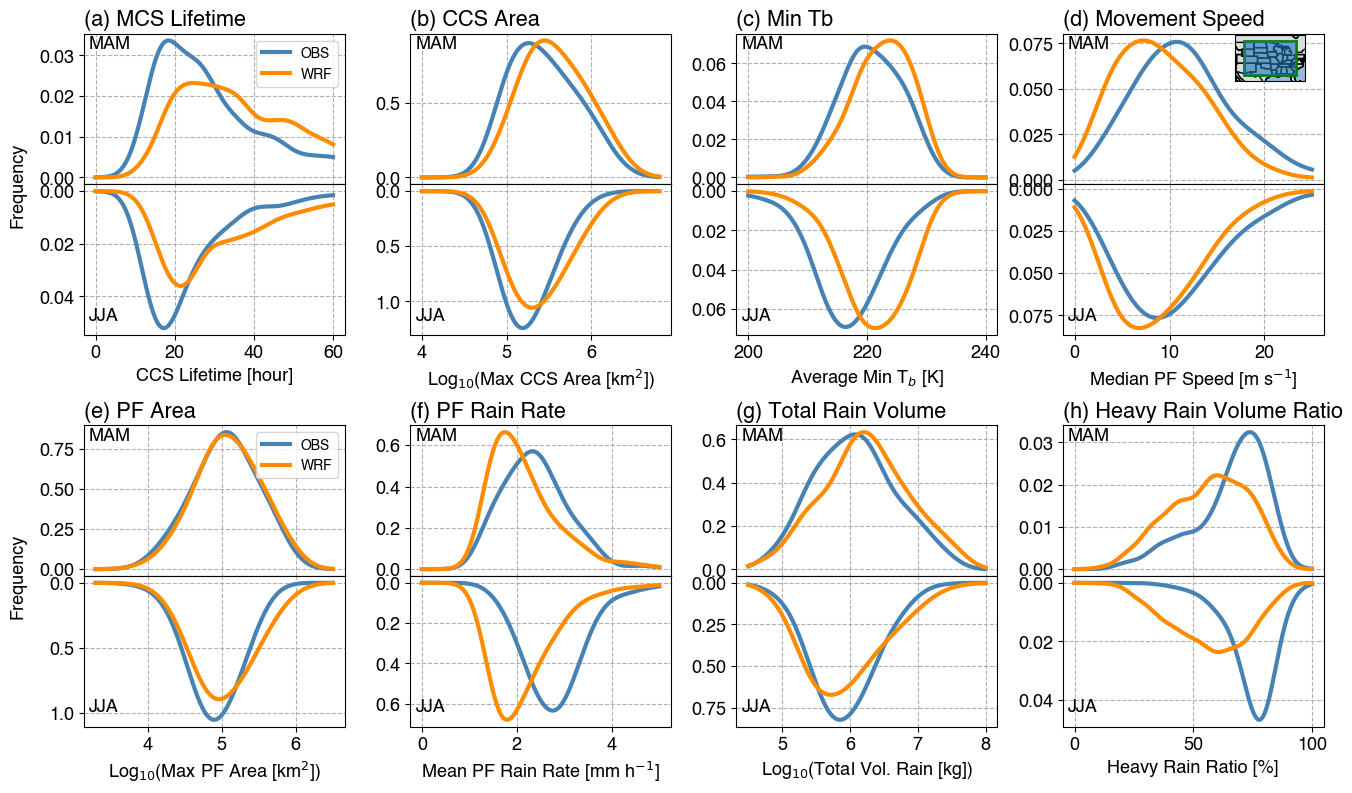

In [50]:
bins = [
    [lifetime_bins, ccsarea_bins, avgmintb_bins, pfspeed_bins],
    [pfarea_bins, pfrainrate_bins, volrain_bins, pfhrr_bins],    
]
data_top = [
    [ccslifetime_dict_MAM, ccsarea_dict_MAM, mintb_dict_MAM, pfspeed_dict_MAM], 
    [pfarea_dict_MAM, pfrainrate_dict_MAM, volrain_dict_MAM, hrr_dict_MAM, ],
]
data_bot = [
    [ccslifetime_dict_JJA, ccsarea_dict_JJA, mintb_dict_JJA, pfspeed_dict_JJA], 
    [pfarea_dict_JJA, pfrainrate_dict_JJA, volrain_dict_JJA, hrr_dict_JJA, ],
]
titles = [
    ['(a) MCS Lifetime', '(b) CCS Area', '(c) Min Tb', '(d) Movement Speed'],
    ['(e) PF Area', '(f) PF Rain Rate', '(g) Total Rain Volume', '(h) Heavy Rain Volume Ratio'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max CCS Area [km$^2$])', 'Average Min T$_b$ [K]', 'Median PF Speed [m s$^{-1}$]', ],
    ['Log$_{10}$(Max PF Area [km$^2$])', 'Mean PF Rain Rate [mm h$^{-1}$]', 'Log$_{10}$(Total Vol. Rain [kg])', 'Heavy Rain Ratio [%]'],
]
ylabels = [['Frequency','','',''], ['Frequency','','','']]
label_topbot = {'top':'MAM', 'bottom':'JJA'}
label_pos = {'top':{'x':0.02, 'y':0.9}, 'bottom':{'x':0.02, 'y':0.1}}
legend_loc = ['upper right', 'upper right']
legend_ncol = [1, 1]
map_panel = {'row': 0, 'col': 3, 'rowsub': 0, 'colsub': 0}
figname = f'{figdir}kde1d_mcs_MAM_JJA_2x4_{region}.png'
fig = plot_pdf_mirror_mxn(2, 4, 2, 1, bins, data_top, data_bot, titles, xlabels, ylabels, legends, figname,
                          map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=map_panel,
                          legend_fontsize=10, legend_loc=legend_loc, legend_ncol=legend_ncol, label_topbot=label_topbot, label_pos=label_pos, 
                          figsize=[16,9])

## Function to plot 1D KDE on (m x n) panels

In [51]:
def plot_pdf_mxn(nrow, ncol, bins, data_arr, titles, xlabels, ylabels, legends, figname,  
                map_extent=None, lonbox=None, latbox=None, inset_param=None, map_panel=[0,0],
                fontsize=12, legend_fontsize=11, legend_loc='best', figsize=None):
    
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    fig = plt.figure(figsize=figsize, constrained_layout=False, dpi=100)
    outer_grid = fig.add_gridspec(nrow, ncol, wspace=0.25, hspace=0.35)

    lw = 3
    lcolors = {
        'obs':'steelblue', 
        'm1': 'darkorange',
    }

    for row in range(0, nrow):
        for col in range(0, ncol): 
            ax = plt.subplot(outer_grid[row,col])
            ax.plot(bins[row][col], data_arr[row][col]['obs'], lcolors['obs'], lw=lw, label=legends['obs'])
            ax.plot(bins[row][col], data_arr[row][col]['m1'], lcolors['m1'], lw=lw, label=legends['m1'])
            # Labels
            if (col == 0): 
                ax.legend(fontsize=legend_fontsize, loc=legend_loc)
            ax.grid(which='major', ls='--')
            ax.set_title(titles[row][col], loc='left')
            ax.set_xlabel(xlabels[row][col])
            # if (col == 0):
            ax.set_ylabel(ylabels[row][col])
            # ax.set_xticks(xticks[col])
            # ax.set_xlim(xlims[col][0], xlims[col][1])
            # ax.set_ylim(ylims[row][0], ylims[row][1])
            
            # Plot inset map
            if (row == map_panel[0]) & (col == map_panel[1]):
                resolution = '110m'
                land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
                ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
                states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', resolution)
                # proj = ccrs.PlateCarree(central_longitude=180)
                proj = ccrs.PlateCarree(central_longitude=0)
                box_proj = ccrs.PlateCarree(central_longitude=0)
                sub_ax = inset_axes(ax, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                    axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                    axes_kwargs=dict(projection=proj))
                sub_ax.set_extent(map_extent, box_proj)
                # Add land, coastlines, borders to inset
                sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
                sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
                sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=4)
                sub_ax.add_feature(states, edgecolor='k', facecolor='none', zorder=4)
                # Define the vertices of the rectangle in the projection coordinates
                x1, y1 = proj.transform_point(lon_bounds[0], lat_bounds[0], proj)
                x2, y2 = proj.transform_point(lon_bounds[1], lat_bounds[1], proj)
                # Plot rectangle
                sub_ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill=None, lw=2, edgecolor='g', zorder=10))
                sub_ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill='g', edgecolor=None, alpha=0.6, zorder=10))

    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

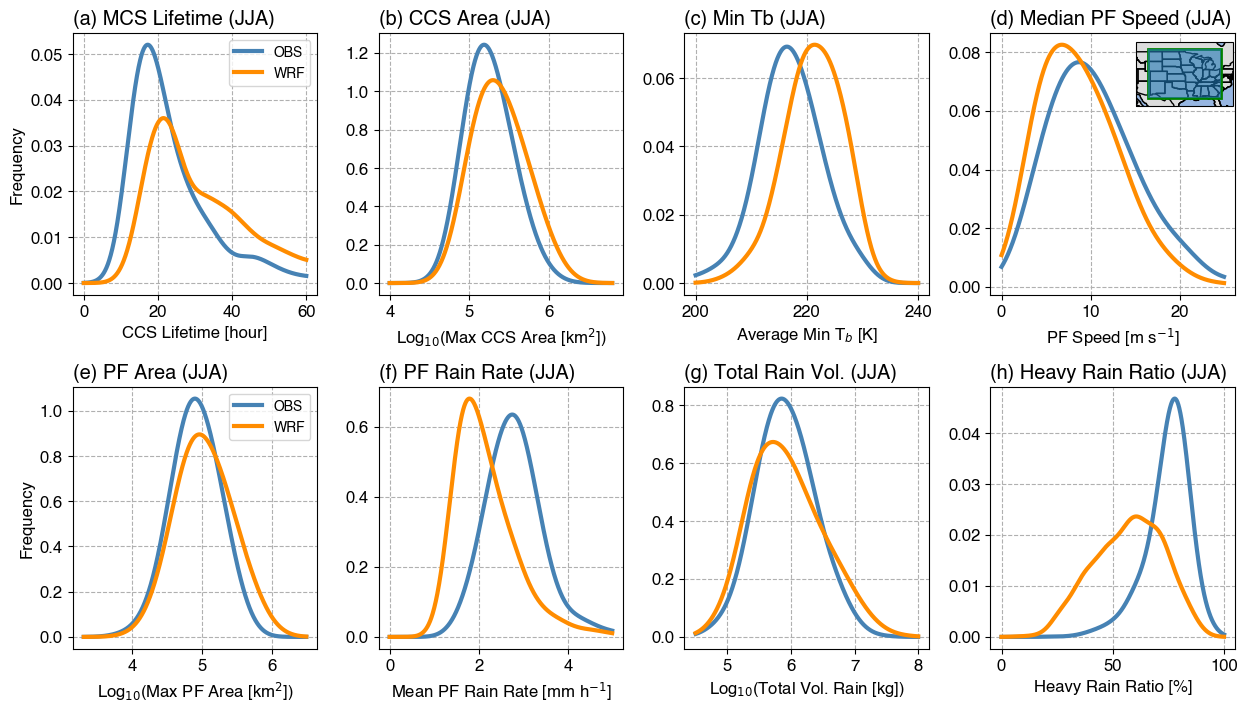

In [52]:
bins = [
    [lifetime_bins, ccsarea_bins, avgmintb_bins, pfspeed_bins],
    [pfarea_bins, pfrainrate_bins, volrain_bins, pfhrr_bins],    
]
data_arr = [
    [ccslifetime_dict_JJA, ccsarea_dict_JJA, mintb_dict_JJA, pfspeed_dict_JJA], 
    [pfarea_dict_JJA, pfrainrate_dict_JJA, volrain_dict_JJA, hrr_dict_JJA, ],
]
titles = [
    ['(a) MCS Lifetime (JJA)', '(b) CCS Area (JJA)', '(c) Min Tb (JJA)', '(d) Median PF Speed (JJA)'],
    ['(e) PF Area (JJA)', '(f) PF Rain Rate (JJA)', '(g) Total Rain Vol. (JJA)', '(h) Heavy Rain Ratio (JJA)'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max CCS Area [km$^2$])', 'Average Min T$_b$ [K]', 'PF Speed [m s$^{-1}$]'],
    ['Log$_{10}$(Max PF Area [km$^2$])', 'Mean PF Rain Rate [mm h$^{-1}$]', 'Log$_{10}$(Total Vol. Rain [kg])', 'Heavy Rain Ratio [%]'],
]
ylabels = [['Frequency','','',''], ['Frequency','','','']]
figname = f'{figdir}kde1d_mcs_JJA_2x4_{region}.png'
fig = plot_pdf_mxn(2, 4, bins, data_arr, titles, xlabels, ylabels, legends, figname,
                   map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,3],
                   legend_fontsize=10, legend_loc='best', figsize=[15,8])

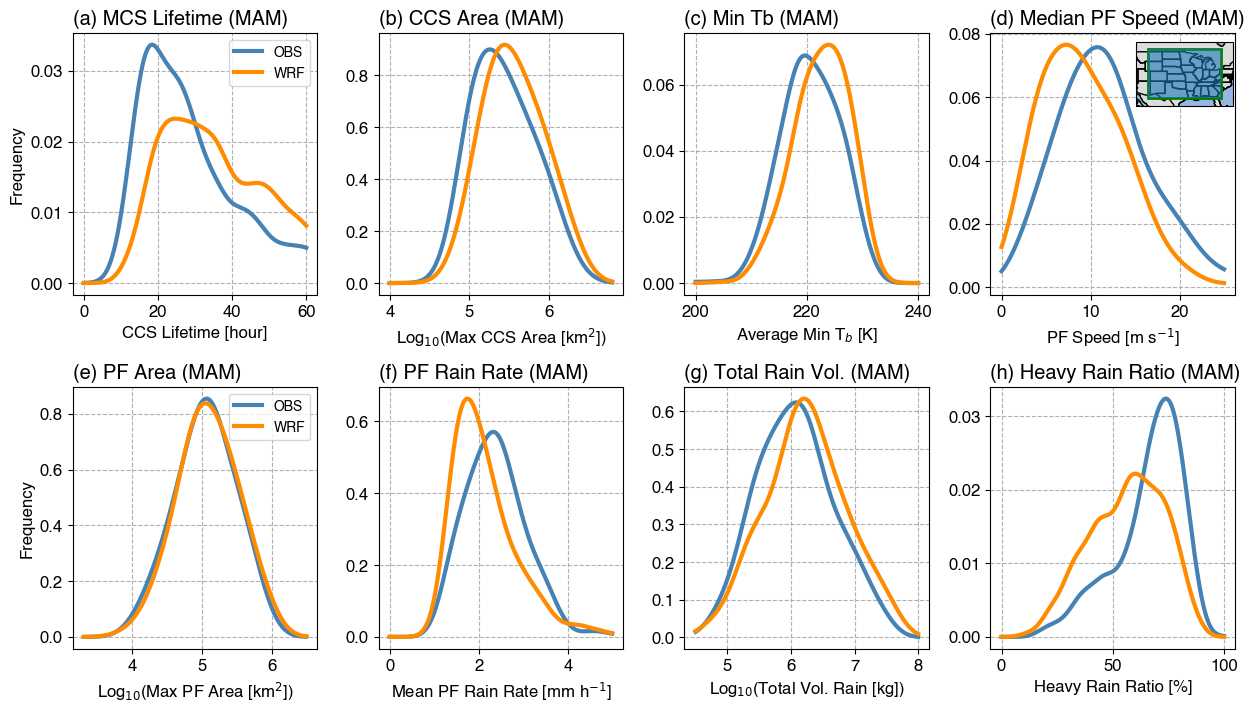

In [53]:
bins = [
    [lifetime_bins, ccsarea_bins, avgmintb_bins, pfspeed_bins],
    [pfarea_bins, pfrainrate_bins, volrain_bins, pfhrr_bins],    
]
data_arr = [
    [ccslifetime_dict_MAM, ccsarea_dict_MAM, mintb_dict_MAM, pfspeed_dict_MAM], 
    [pfarea_dict_MAM, pfrainrate_dict_MAM, volrain_dict_MAM, hrr_dict_MAM, ],
]
titles = [
    ['(a) MCS Lifetime (MAM)', '(b) CCS Area (MAM)', '(c) Min Tb (MAM)', '(d) Median PF Speed (MAM)'],
    ['(e) PF Area (MAM)', '(f) PF Rain Rate (MAM)', '(g) Total Rain Vol. (MAM)', '(h) Heavy Rain Ratio (MAM)'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max CCS Area [km$^2$])', 'Average Min T$_b$ [K]', 'PF Speed [m s$^{-1}$]'],
    ['Log$_{10}$(Max PF Area [km$^2$])', 'Mean PF Rain Rate [mm h$^{-1}$]', 'Log$_{10}$(Total Vol. Rain [kg])', 'Heavy Rain Ratio [%]'],
]
ylabels = [['Frequency','','',''], ['Frequency','','','']]
figname = f'{figdir}kde1d_mcs_MAM_2x4_{region}.png'
fig = plot_pdf_mxn(2, 4, bins, data_arr, titles, xlabels, ylabels, legends, figname,
                   map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,3],
                   legend_fontsize=10, legend_loc='best', figsize=[15,8])

In [54]:
figdir

'/global/cfs/cdirs/m2637/zfeng/TGW_MCS/figures/'

## Function to composite track time-evolution by 1 condition

In [55]:
import warnings
def get_comp_tracks_by1cond(in_var, x_cond_var, x_cond_range, quantiles):
    # Suppress RuntimeWarning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        # Filter by one condition
        in_var_cond = in_var.where((x_cond_var >= x_cond_range[0]) & (x_cond_var <= x_cond_range[1]), drop=True)
        nsamples = in_var_cond.sizes['tracks']
        out_var_mean = in_var_cond.mean(dim='tracks')
        out_var_qntl = in_var_cond.quantile(quantiles, dim='tracks')
    return out_var_mean, out_var_qntl, nsamples

## Composite MCS time-evolution by CCS lifetime (for non-merge-split tracks only)
- Note the use of Dataset (ds_nms)

In [56]:
# Set lifetime range for composites
lifetime_range1 = [12, 15]
lifetime_range2 = [18, 27]
quantiles = [0.25, 0.5, 0.75]

# Add mergers/splits to get total CCS area
ccsarea_l_obs = ds_nms_l_obs.ccs_area + ds_nms_l_obs.merge_ccs_area.sum(dim='mergers') + ds_nms_l_obs.split_ccs_area.sum(dim='mergers')
ccsarea_l_m1 = ds_nms_l_m1.ccs_area + ds_nms_l_m1.merge_ccs_area.sum(dim='mergers') + ds_nms_l_m1.split_ccs_area.sum(dim='mergers')
# CCS lifetime
ccslifetime_l_obs = ds_nms_l_obs.track_duration * time_res_obs
ccslifetime_l_m1 = ds_nms_l_m1.track_duration * time_res_m1
# By season
ccslifetime_l_obs_MAM = ccslifetime_l_obs.where(start_season_obs == 'MAM', drop=True)
ccslifetime_l_obs_JJA = ccslifetime_l_obs.where(start_season_obs == 'JJA', drop=True)
ccslifetime_l_m1_MAM = ccslifetime_l_m1.where(start_season_m1 == 'MAM', drop=True)
ccslifetime_l_m1_JJA = ccslifetime_l_m1.where(start_season_m1 == 'JJA', drop=True)

ccsarea_l_obs_MAM = ccsarea_l_obs.where(start_season_obs == 'MAM', drop=True)
ccsarea_l_obs_JJA = ccsarea_l_obs.where(start_season_obs == 'JJA', drop=True)
ccsarea_l_m1_MAM = ccsarea_l_m1.where(start_season_m1 == 'MAM', drop=True)
ccsarea_l_m1_JJA = ccsarea_l_m1.where(start_season_m1 == 'JJA', drop=True)

# CCS Area
avg1_ccsarea_l_obs_MAM, qntl1_ccsarea_l_obs_MAM, ns1_l_obs_MAM = get_comp_tracks_by1cond(ccsarea_l_obs_MAM, ccslifetime_l_obs_MAM, lifetime_range1, quantiles)
avg2_ccsarea_l_obs_MAM, qntl2_ccsarea_l_obs_MAM, ns2_l_obs_MAM = get_comp_tracks_by1cond(ccsarea_l_obs_MAM, ccslifetime_l_obs_MAM, lifetime_range2, quantiles)
avg1_ccsarea_l_obs_JJA, qntl1_ccsarea_l_obs_JJA, ns1_l_obs_JJA = get_comp_tracks_by1cond(ccsarea_l_obs_JJA, ccslifetime_l_obs_JJA, lifetime_range1, quantiles)
avg2_ccsarea_l_obs_JJA, qntl2_ccsarea_l_obs_JJA, ns2_l_obs_JJA = get_comp_tracks_by1cond(ccsarea_l_obs_JJA, ccslifetime_l_obs_JJA, lifetime_range2, quantiles)

avg1_ccsarea_l_m1_MAM, qntl1_ccsarea_l_m1_MAM, ns1_l_m1_MAM = get_comp_tracks_by1cond(ccsarea_l_m1_MAM, ccslifetime_l_m1_MAM, lifetime_range1, quantiles)
avg2_ccsarea_l_m1_MAM, qntl2_ccsarea_l_m1_MAM, ns2_l_m1_MAM = get_comp_tracks_by1cond(ccsarea_l_m1_MAM, ccslifetime_l_m1_MAM, lifetime_range2, quantiles)
avg1_ccsarea_l_m1_JJA, qntl1_ccsarea_l_m1_JJA, ns1_l_m1_JJA = get_comp_tracks_by1cond(ccsarea_l_m1_JJA, ccslifetime_l_m1_JJA, lifetime_range1, quantiles)
avg2_ccsarea_l_m1_JJA, qntl2_ccsarea_l_m1_JJA, ns2_l_m1_JJA = get_comp_tracks_by1cond(ccsarea_l_m1_JJA, ccslifetime_l_m1_JJA, lifetime_range2, quantiles)
print(f'Sample number (range1) MAM: {ns1_l_obs_MAM} (OBS), {ns1_l_m1_MAM} (WRF)')
print(f'Sample number (range2) MAM: {ns2_l_obs_MAM} (OBS), {ns2_l_m1_MAM} (WRF)')
print(f'Sample number (range1) JJA: {ns1_l_obs_JJA} (OBS), {ns1_l_m1_JJA} (WRF)')
print(f'Sample number (range2) JJA: {ns2_l_obs_JJA} (OBS), {ns2_l_m1_JJA} (WRF)')

Sample number (range1) MAM: 118 (OBS), 23 (WRF)
Sample number (range2) MAM: 312 (OBS), 186 (WRF)
Sample number (range1) JJA: 635 (OBS), 100 (WRF)
Sample number (range2) JJA: 1090 (OBS), 623 (WRF)


In [57]:
# Min Tb
ccs_mintb_l_obs_MAM = ds_nms_l_obs.corecold_mintb.where(start_season_obs == 'MAM', drop=True)
ccs_mintb_l_obs_JJA = ds_nms_l_obs.corecold_mintb.where(start_season_obs == 'JJA', drop=True)
ccs_mintb_l_m1_MAM = ds_nms_l_m1.corecold_mintb.where(start_season_m1 == 'MAM', drop=True)
ccs_mintb_l_m1_JJA = ds_nms_l_m1.corecold_mintb.where(start_season_m1 == 'JJA', drop=True)

avg1_mintb_l_obs_MAM, qntl1_mintb_l_obs_MAM, ns1_l_obs_MAM = get_comp_tracks_by1cond(ccs_mintb_l_obs_MAM, ccslifetime_l_obs_MAM, lifetime_range1, quantiles)
avg2_mintb_l_obs_MAM, qntl2_mintb_l_obs_MAM, ns2_l_obs_MAM = get_comp_tracks_by1cond(ccs_mintb_l_obs_MAM, ccslifetime_l_obs_MAM, lifetime_range2, quantiles)
avg1_mintb_l_obs_JJA, qntl1_mintb_l_obs_JJA, ns1_l_obs_JJA = get_comp_tracks_by1cond(ccs_mintb_l_obs_JJA, ccslifetime_l_obs_JJA, lifetime_range1, quantiles)
avg2_mintb_l_obs_JJA, qntl2_mintb_l_obs_JJA, ns2_l_obs_JJA = get_comp_tracks_by1cond(ccs_mintb_l_obs_JJA, ccslifetime_l_obs_JJA, lifetime_range2, quantiles)

avg1_mintb_l_m1_MAM, qntl1_mintb_l_m1_MAM, ns1_l_m1_MAM = get_comp_tracks_by1cond(ccs_mintb_l_m1_MAM, ccslifetime_l_m1_MAM, lifetime_range1, quantiles)
avg2_mintb_l_m1_MAM, qntl2_mintb_l_m1_MAM, ns2_l_m1_MAM = get_comp_tracks_by1cond(ccs_mintb_l_m1_MAM, ccslifetime_l_m1_MAM, lifetime_range2, quantiles)
avg1_mintb_l_m1_JJA, qntl1_mintb_l_m1_JJA, ns1_l_m1_JJA = get_comp_tracks_by1cond(ccs_mintb_l_m1_JJA, ccslifetime_l_m1_JJA, lifetime_range1, quantiles)
avg2_mintb_l_m1_JJA, qntl2_mintb_l_m1_JJA, ns2_l_m1_JJA = get_comp_tracks_by1cond(ccs_mintb_l_m1_JJA, ccslifetime_l_m1_JJA, lifetime_range2, quantiles)

In [58]:
# Largest PF Area
pf_area_l_obs_MAM = ds_nms_l_obs.pf_area.isel(nmaxpf=0).where(start_season_obs == 'MAM', drop=True)
pf_area_l_obs_JJA = ds_nms_l_obs.pf_area.isel(nmaxpf=0).where(start_season_obs == 'JJA', drop=True)
pf_area_l_m1_MAM = ds_nms_l_m1.pf_area.isel(nmaxpf=0).where(start_season_m1 == 'MAM', drop=True)
pf_area_l_m1_JJA = ds_nms_l_m1.pf_area.isel(nmaxpf=0).where(start_season_m1 == 'JJA', drop=True)

avg1_pfarea_l_obs_MAM, qntl1_pfarea_l_obs_MAM, ns1_l_obs_MAM = get_comp_tracks_by1cond(pf_area_l_obs_MAM, ccslifetime_l_obs_MAM, lifetime_range1, quantiles)
avg2_pfarea_l_obs_MAM, qntl2_pfarea_l_obs_MAM, ns2_l_obs_MAM = get_comp_tracks_by1cond(pf_area_l_obs_MAM, ccslifetime_l_obs_MAM, lifetime_range2, quantiles)
avg1_pfarea_l_obs_JJA, qntl1_pfarea_l_obs_JJA, ns1_l_obs_JJA = get_comp_tracks_by1cond(pf_area_l_obs_JJA, ccslifetime_l_obs_JJA, lifetime_range1, quantiles)
avg2_pfarea_l_obs_JJA, qntl2_pfarea_l_obs_JJA, ns2_l_obs_JJA = get_comp_tracks_by1cond(pf_area_l_obs_JJA, ccslifetime_l_obs_JJA, lifetime_range2, quantiles)

avg1_pfarea_l_m1_MAM, qntl1_pfarea_l_m1_MAM, ns1_l_m1_MAM = get_comp_tracks_by1cond(pf_area_l_m1_MAM, ccslifetime_l_m1_MAM, lifetime_range1, quantiles)
avg2_pfarea_l_m1_MAM, qntl2_pfarea_l_m1_MAM, ns2_l_m1_MAM = get_comp_tracks_by1cond(pf_area_l_m1_MAM, ccslifetime_l_m1_MAM, lifetime_range2, quantiles)
avg1_pfarea_l_m1_JJA, qntl1_pfarea_l_m1_JJA, ns1_l_m1_JJA = get_comp_tracks_by1cond(pf_area_l_m1_JJA, ccslifetime_l_m1_JJA, lifetime_range1, quantiles)
avg2_pfarea_l_m1_JJA, qntl2_pfarea_l_m1_JJA, ns2_l_m1_JJA = get_comp_tracks_by1cond(pf_area_l_m1_JJA, ccslifetime_l_m1_JJA, lifetime_range2, quantiles)

In [59]:
# Largest PF Equivalent Diameter
pfdiam_l_obs_MAM = 2*np.sqrt(ds_nms_l_obs.pf_area.isel(nmaxpf=0).where(start_season_obs == 'MAM', drop=True) / np.pi)
pfdiam_l_obs_JJA = 2*np.sqrt(ds_nms_l_obs.pf_area.isel(nmaxpf=0).where(start_season_obs == 'JJA', drop=True) / np.pi)
pfdiam_l_m1_MAM = 2*np.sqrt(ds_nms_l_m1.pf_area.isel(nmaxpf=0).where(start_season_m1 == 'MAM', drop=True) / np.pi)
pfdiam_l_m1_JJA = 2*np.sqrt(ds_nms_l_m1.pf_area.isel(nmaxpf=0).where(start_season_m1 == 'JJA', drop=True) / np.pi)

avg1_pfdiam_l_obs_MAM, qntl1_pfdiam_l_obs_MAM, ns1_l_obs_MAM = get_comp_tracks_by1cond(pfdiam_l_obs_MAM, ccslifetime_l_obs_MAM, lifetime_range1, quantiles)
avg2_pfdiam_l_obs_MAM, qntl2_pfdiam_l_obs_MAM, ns2_l_obs_MAM = get_comp_tracks_by1cond(pfdiam_l_obs_MAM, ccslifetime_l_obs_MAM, lifetime_range2, quantiles)
avg1_pfdiam_l_obs_JJA, qntl1_pfdiam_l_obs_JJA, ns1_l_obs_JJA = get_comp_tracks_by1cond(pfdiam_l_obs_JJA, ccslifetime_l_obs_JJA, lifetime_range1, quantiles)
avg2_pfdiam_l_obs_JJA, qntl2_pfdiam_l_obs_JJA, ns2_l_obs_JJA = get_comp_tracks_by1cond(pfdiam_l_obs_JJA, ccslifetime_l_obs_JJA, lifetime_range2, quantiles)

avg1_pfdiam_l_m1_MAM, qntl1_pfdiam_l_m1_MAM, ns1_l_m1_MAM = get_comp_tracks_by1cond(pfdiam_l_m1_MAM, ccslifetime_l_m1_MAM, lifetime_range1, quantiles)
avg2_pfdiam_l_m1_MAM, qntl2_pfdiam_l_m1_MAM, ns2_l_m1_MAM = get_comp_tracks_by1cond(pfdiam_l_m1_MAM, ccslifetime_l_m1_MAM, lifetime_range2, quantiles)
avg1_pfdiam_l_m1_JJA, qntl1_pfdiam_l_m1_JJA, ns1_l_m1_JJA = get_comp_tracks_by1cond(pfdiam_l_m1_JJA, ccslifetime_l_m1_JJA, lifetime_range1, quantiles)
avg2_pfdiam_l_m1_JJA, qntl2_pfdiam_l_m1_JJA, ns2_l_m1_JJA = get_comp_tracks_by1cond(pfdiam_l_m1_JJA, ccslifetime_l_m1_JJA, lifetime_range2, quantiles)

In [60]:
# Largest PF Rain Rate
pfrainrate_l_obs_MAM = ds_nms_l_obs.pf_rainrate.isel(nmaxpf=0).where(start_season_obs == 'MAM', drop=True)
pfrainrate_l_obs_JJA = ds_nms_l_obs.pf_rainrate.isel(nmaxpf=0).where(start_season_obs == 'JJA', drop=True)
pfrainrate_l_m1_MAM = ds_nms_l_m1.pf_rainrate.isel(nmaxpf=0).where(start_season_m1 == 'MAM', drop=True)
pfrainrate_l_m1_JJA = ds_nms_l_m1.pf_rainrate.isel(nmaxpf=0).where(start_season_m1 == 'JJA', drop=True)

avg1_pfrainrate_l_obs_MAM, qntl1_pfrainrate_l_obs_MAM, ns1_l_obs_MAM = get_comp_tracks_by1cond(pfrainrate_l_obs_MAM, ccslifetime_l_obs_MAM, lifetime_range1, quantiles)
avg2_pfrainrate_l_obs_MAM, qntl2_pfrainrate_l_obs_MAM, ns2_l_obs_MAM = get_comp_tracks_by1cond(pfrainrate_l_obs_MAM, ccslifetime_l_obs_MAM, lifetime_range2, quantiles)
avg1_pfrainrate_l_obs_JJA, qntl1_pfrainrate_l_obs_JJA, ns1_l_obs_JJA = get_comp_tracks_by1cond(pfrainrate_l_obs_JJA, ccslifetime_l_obs_JJA, lifetime_range1, quantiles)
avg2_pfrainrate_l_obs_JJA, qntl2_pfrainrate_l_obs_JJA, ns2_l_obs_JJA = get_comp_tracks_by1cond(pfrainrate_l_obs_JJA, ccslifetime_l_obs_JJA, lifetime_range2, quantiles)

avg1_pfrainrate_l_m1_MAM, qntl1_pfrainrate_l_m1_MAM, ns1_l_m1_MAM = get_comp_tracks_by1cond(pfrainrate_l_m1_MAM, ccslifetime_l_m1_MAM, lifetime_range1, quantiles)
avg2_pfrainrate_l_m1_MAM, qntl2_pfrainrate_l_m1_MAM, ns2_l_m1_MAM = get_comp_tracks_by1cond(pfrainrate_l_m1_MAM, ccslifetime_l_m1_MAM, lifetime_range2, quantiles)
avg1_pfrainrate_l_m1_JJA, qntl1_pfrainrate_l_m1_JJA, ns1_l_m1_JJA = get_comp_tracks_by1cond(pfrainrate_l_m1_JJA, ccslifetime_l_m1_JJA, lifetime_range1, quantiles)
avg2_pfrainrate_l_m1_JJA, qntl2_pfrainrate_l_m1_JJA, ns2_l_m1_JJA = get_comp_tracks_by1cond(pfrainrate_l_m1_JJA, ccslifetime_l_m1_JJA, lifetime_range2, quantiles)

In [61]:
# Volume Rain Rate [kg/h]
pfvolrain_l_obs_MAM = ds_nms_l_obs.total_rain.where(start_season_obs == 'MAM', drop=True) * pixel_radius_obs**2
pfvolrain_l_obs_JJA = ds_nms_l_obs.total_rain.where(start_season_obs == 'JJA', drop=True) * pixel_radius_obs**2
pfvolrain_l_m1_MAM = ds_nms_l_m1.total_rain.where(start_season_m1 == 'MAM', drop=True) * pixel_radius_m1**2
pfvolrain_l_m1_JJA = ds_nms_l_m1.total_rain.where(start_season_m1 == 'JJA', drop=True) * pixel_radius_m1**2

avg1_pfvolrain_l_obs_MAM, qntl1_pfvolrain_l_obs_MAM, ns1_l_obs_MAM = get_comp_tracks_by1cond(pfvolrain_l_obs_MAM, ccslifetime_l_obs_MAM, lifetime_range1, quantiles)
avg2_pfvolrain_l_obs_MAM, qntl2_pfvolrain_l_obs_MAM, ns2_l_obs_MAM = get_comp_tracks_by1cond(pfvolrain_l_obs_MAM, ccslifetime_l_obs_MAM, lifetime_range2, quantiles)
avg1_pfvolrain_l_obs_JJA, qntl1_pfvolrain_l_obs_JJA, ns1_l_obs_JJA = get_comp_tracks_by1cond(pfvolrain_l_obs_JJA, ccslifetime_l_obs_JJA, lifetime_range1, quantiles)
avg2_pfvolrain_l_obs_JJA, qntl2_pfvolrain_l_obs_JJA, ns2_l_obs_JJA = get_comp_tracks_by1cond(pfvolrain_l_obs_JJA, ccslifetime_l_obs_JJA, lifetime_range2, quantiles)

avg1_pfvolrain_l_m1_MAM, qntl1_pfvolrain_l_m1_MAM, ns1_l_m1_MAM = get_comp_tracks_by1cond(pfvolrain_l_m1_MAM, ccslifetime_l_m1_MAM, lifetime_range1, quantiles)
avg2_pfvolrain_l_m1_MAM, qntl2_pfvolrain_l_m1_MAM, ns2_l_m1_MAM = get_comp_tracks_by1cond(pfvolrain_l_m1_MAM, ccslifetime_l_m1_MAM, lifetime_range2, quantiles)
avg1_pfvolrain_l_m1_JJA, qntl1_pfvolrain_l_m1_JJA, ns1_l_m1_JJA = get_comp_tracks_by1cond(pfvolrain_l_m1_JJA, ccslifetime_l_m1_JJA, lifetime_range1, quantiles)
avg2_pfvolrain_l_m1_JJA, qntl2_pfvolrain_l_m1_JJA, ns2_l_m1_JJA = get_comp_tracks_by1cond(pfvolrain_l_m1_JJA, ccslifetime_l_m1_JJA, lifetime_range2, quantiles)

## Function to plot composite track time-evolution variables

In [62]:
def plot_evolution_mxn(nrow, ncol, hours_obs, hours_m1, dataavg_obs, dataqntl_obs, dataavg_m1, dataqntl_m1, ns_obs, ns_m1,  
                        titles=None, xlabels=None, ylabels=None, xticks=None, xlims=None, ylims=None, legends=None, 
                        map_extent=None, lon_bounds=None, lat_bounds=None, inset_param=None, figname=None, figsize=None,
                        fontsize=None, legend_fontsize=None, legend_loc='best'):
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    colors = {'o':'steelblue', 'm':'darkorange'}
    # Setup figure
    fig = plt.figure(figsize=figsize, constrained_layout=False, dpi=100)
    outer_grid = fig.add_gridspec(nrow, ncol, wspace=0.25, hspace=0.35)
    # Loop over row and column
    for row in range(0, nrow):
        for col in range(0, ncol): 
            ax = plt.subplot(outer_grid[row,col])
            ax.plot(hours_obs[col], dataavg_obs[row][col], colors['o'], lw=3, label=legends[col]['o'])
            ax.plot(hours_m1[col], dataavg_m1[row][col], colors['m'], lw=3, label=legends[col]['m'])
            ax.fill_between(hours_obs[col], dataqntl_obs[row][col][0], dataqntl_obs[row][col][1], facecolor=colors['o'],  alpha=0.3)
            ax.fill_between(hours_m1[col], dataqntl_m1[row][col][0], dataqntl_m1[row][col][1], facecolor=colors['m'],  alpha=0.3)
            if (row == 0): 
                ax.legend(fontsize=legend_fontsize, loc=legend_loc)
            ax.grid(which='major', ls='--')
            ax.set_title(titles[row][col], loc='left')
            ax.set_xlabel(xlabels[row])
            ax.set_ylabel(ylabels[row])
            ax.set_xticks(xticks[col])
            ax.set_xlim(xlims[col][0], xlims[col][1])
            ax.set_ylim(ylims[row][0], ylims[row][1])
            
            # Plot inset map
            if (row == 0):               
                resolution = '110m'
                land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
                ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
                states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', resolution)
                proj = ccrs.PlateCarree(central_longitude=0)
                box_proj = ccrs.PlateCarree(central_longitude=0)
                sub_ax = inset_axes(ax, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                    axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                    axes_kwargs=dict(projection=proj))
                sub_ax.set_extent(map_extent, box_proj)
                # Add land, coastlines, borders to inset
                sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
                sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
                sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=4)
                sub_ax.add_feature(states, edgecolor='k', facecolor='none', zorder=4)
                # Define the vertices of the rectangle in the projection coordinates
                x1, y1 = proj.transform_point(lon_bounds[0], lat_bounds[0], proj)
                x2, y2 = proj.transform_point(lon_bounds[1], lat_bounds[1], proj)
                # Plot rectangle
                sub_ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill=None, lw=2, edgecolor='g', zorder=10))
                sub_ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill='g', edgecolor=None, alpha=0.6, zorder=10))

    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

In [63]:
lon_bounds, lat_bounds, region

([-110, -80], [30, 50], 'USA')

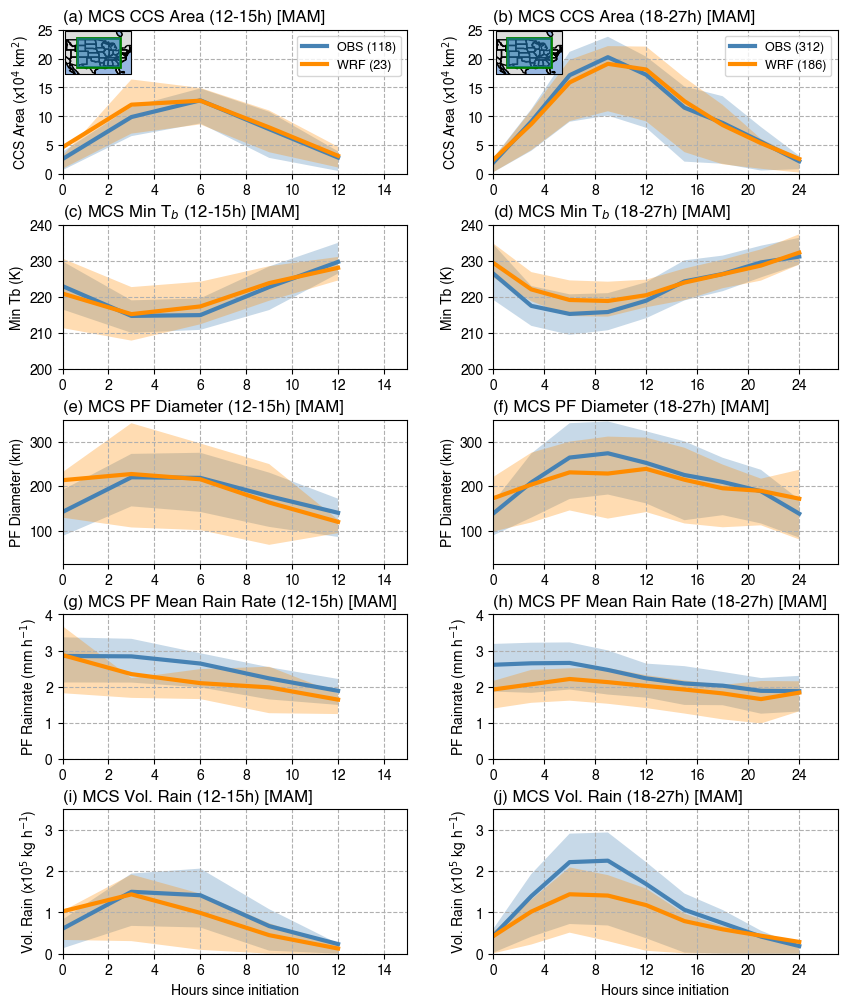

In [64]:
hours_obs = [avg1_ccsarea_l_obs_MAM.times * time_res_obs, avg2_ccsarea_l_obs_MAM.times * time_res_obs]
hours_m1 = [avg1_ccsarea_l_m1_MAM.times * time_res_m1, avg2_ccsarea_l_m1_MAM.times * time_res_m1]
dataavg_obs = [[avg1_ccsarea_l_obs_MAM/1e4, avg2_ccsarea_l_obs_MAM/1e4],
            [avg1_mintb_l_obs_MAM, avg2_mintb_l_obs_MAM],
            [avg1_pfdiam_l_obs_MAM, avg2_pfdiam_l_obs_MAM], 
            [avg1_pfrainrate_l_obs_MAM, avg2_pfrainrate_l_obs_MAM],
            [avg1_pfvolrain_l_obs_MAM/1e5, avg2_pfvolrain_l_obs_MAM/1e5]]
dataavg_m1 = [[avg1_ccsarea_l_m1_MAM/1e4, avg2_ccsarea_l_m1_MAM/1e4],
            [avg1_mintb_l_m1_MAM, avg2_mintb_l_m1_MAM],
            [avg1_pfdiam_l_m1_MAM, avg2_pfdiam_l_m1_MAM], 
            [avg1_pfrainrate_l_m1_MAM, avg2_pfrainrate_l_m1_MAM],
            [avg1_pfvolrain_l_m1_MAM/1e5, avg2_pfvolrain_l_m1_MAM/1e5]]
dataqntl_obs = [[(qntl1_ccsarea_l_obs_MAM.sel(quantile=0.25)/1e4,qntl1_ccsarea_l_obs_MAM.sel(quantile=0.75)/1e4), 
                 (qntl2_ccsarea_l_obs_MAM.sel(quantile=0.25)/1e4,qntl2_ccsarea_l_obs_MAM.sel(quantile=0.75)/1e4)],
                [(qntl1_mintb_l_obs_MAM.sel(quantile=0.25),qntl1_mintb_l_obs_MAM.sel(quantile=0.75)), 
                 (qntl2_mintb_l_obs_MAM.sel(quantile=0.25),qntl2_mintb_l_obs_MAM.sel(quantile=0.75))],
                [(qntl1_pfdiam_l_obs_MAM.sel(quantile=0.25),qntl1_pfdiam_l_obs_MAM.sel(quantile=0.75)), 
                 (qntl2_pfdiam_l_obs_MAM.sel(quantile=0.25),qntl2_pfdiam_l_obs_MAM.sel(quantile=0.75))],
                [(qntl1_pfrainrate_l_obs_MAM.sel(quantile=0.25),qntl1_pfrainrate_l_obs_MAM.sel(quantile=0.75)), 
                 (qntl2_pfrainrate_l_obs_MAM.sel(quantile=0.25),qntl2_pfrainrate_l_obs_MAM.sel(quantile=0.75))],
                [(qntl1_pfvolrain_l_obs_MAM.sel(quantile=0.25)/1e5,qntl1_pfvolrain_l_obs_MAM.sel(quantile=0.75)/1e5), 
                 (qntl2_pfvolrain_l_obs_MAM.sel(quantile=0.25)/1e5,qntl2_pfvolrain_l_obs_MAM.sel(quantile=0.75)/1e5)],]
dataqntl_m1 = [[(qntl1_ccsarea_l_m1_MAM.sel(quantile=0.25)/1e4,qntl1_ccsarea_l_m1_MAM.sel(quantile=0.75)/1e4), 
                 (qntl2_ccsarea_l_m1_MAM.sel(quantile=0.25)/1e4,qntl2_ccsarea_l_m1_MAM.sel(quantile=0.75)/1e4)],
                [(qntl1_mintb_l_m1_MAM.sel(quantile=0.25),qntl1_mintb_l_m1_MAM.sel(quantile=0.75)), 
                 (qntl2_mintb_l_m1_MAM.sel(quantile=0.25),qntl2_mintb_l_m1_MAM.sel(quantile=0.75))],
                [(qntl1_pfdiam_l_m1_MAM.sel(quantile=0.25),qntl1_pfdiam_l_m1_MAM.sel(quantile=0.75)), 
                 (qntl2_pfdiam_l_m1_MAM.sel(quantile=0.25),qntl2_pfdiam_l_m1_MAM.sel(quantile=0.75))],
                [(qntl1_pfrainrate_l_m1_MAM.sel(quantile=0.25),qntl1_pfrainrate_l_m1_MAM.sel(quantile=0.75)), 
                 (qntl2_pfrainrate_l_m1_MAM.sel(quantile=0.25),qntl2_pfrainrate_l_m1_MAM.sel(quantile=0.75))],
                [(qntl1_pfvolrain_l_m1_MAM.sel(quantile=0.25)/1e5,qntl1_pfvolrain_l_m1_MAM.sel(quantile=0.75)/1e5), 
                 (qntl2_pfvolrain_l_m1_MAM.sel(quantile=0.25)/1e5,qntl2_pfvolrain_l_m1_MAM.sel(quantile=0.75)/1e5)],]
ns_obs = [ns1_l_obs_MAM, ns2_l_obs_MAM]
ns_m1 = [ns1_l_m1_MAM, ns2_l_m1_MAM]
titles = []
titles = [[f'(a) MCS CCS Area ({lifetime_range1[0]}-{lifetime_range1[1]}h) [MAM]', f'(b) MCS CCS Area ({lifetime_range2[0]}-{lifetime_range2[1]}h) [MAM]'],
          [f'(c) MCS Min T$_b$ ({lifetime_range1[0]}-{lifetime_range1[1]}h) [MAM]', f'(d) MCS Min T$_b$ ({lifetime_range2[0]}-{lifetime_range2[1]}h) [MAM]'],
          [f'(e) MCS PF Diameter ({lifetime_range1[0]}-{lifetime_range1[1]}h) [MAM]', f'(f) MCS PF Diameter ({lifetime_range2[0]}-{lifetime_range2[1]}h) [MAM]'],
          [f'(g) MCS PF Mean Rain Rate ({lifetime_range1[0]}-{lifetime_range1[1]}h) [MAM]', f'(h) MCS PF Mean Rain Rate ({lifetime_range2[0]}-{lifetime_range2[1]}h) [MAM]'],
          [f'(i) MCS Vol. Rain ({lifetime_range1[0]}-{lifetime_range1[1]}h) [MAM]', f'(j) MCS Vol. Rain ({lifetime_range2[0]}-{lifetime_range2[1]}h) [MAM]']]
xlabels = ['','','','','Hours since initiation']
ylabels = ['CCS Area (x10$^{4}$ km$^2$)', 'Min Tb (K)', 'PF Diameter (km)', 'PF Rainrate (mm h$^{-1}$)', 'Vol. Rain (x10$^{5}$ kg h$^{-1}$)', ]
xticks = [np.arange(0, max(lifetime_range1)+1, 2), np.arange(0, max(lifetime_range2)+1, 4)]
xlims = [(0, max(lifetime_range1)), (0, max(lifetime_range2))]
#ylims = [(0,25), (190,235), (20,250), (2,14), (0,5)]
ylims = [(0,25), (200,240), (25,350), (0,4), (0,3.5)]
legends = [{'o':f'OBS ({ns1_l_obs_MAM})', 'm':f'WRF ({ns1_l_m1_MAM})'}, {'o':f'OBS ({ns2_l_obs_MAM})', 'm':f'WRF ({ns2_l_m1_MAM})'}]
figname = f'{figdir}mcs_composite_evolution_{region}_MAM.png'

bounds = [lon_bounds[0], lon_bounds[1]-0.1, lat_bounds[0], lat_bounds[1]]
map_extent = [bounds[0]-8,bounds[1]+8,bounds[2]-5,bounds[3]+5]
inset_param = {'width':'20%', 'height':'30%', 'loc':'upper left', 'borderpad':0.1}

fig = plot_evolution_mxn(5, 2, hours_obs, hours_m1, dataavg_obs, dataqntl_obs, dataavg_m1, dataqntl_m1, ns_obs, ns_m1,  
                          titles=titles, xlabels=xlabels, ylabels=ylabels, xticks=xticks, xlims=xlims, ylims=ylims, legends=legends, 
                          map_extent=map_extent, lon_bounds=lon_bounds, lat_bounds=lat_bounds, inset_param=inset_param, figname=figname, figsize=[10,12],
                          fontsize=10, legend_fontsize=9, legend_loc='upper right')

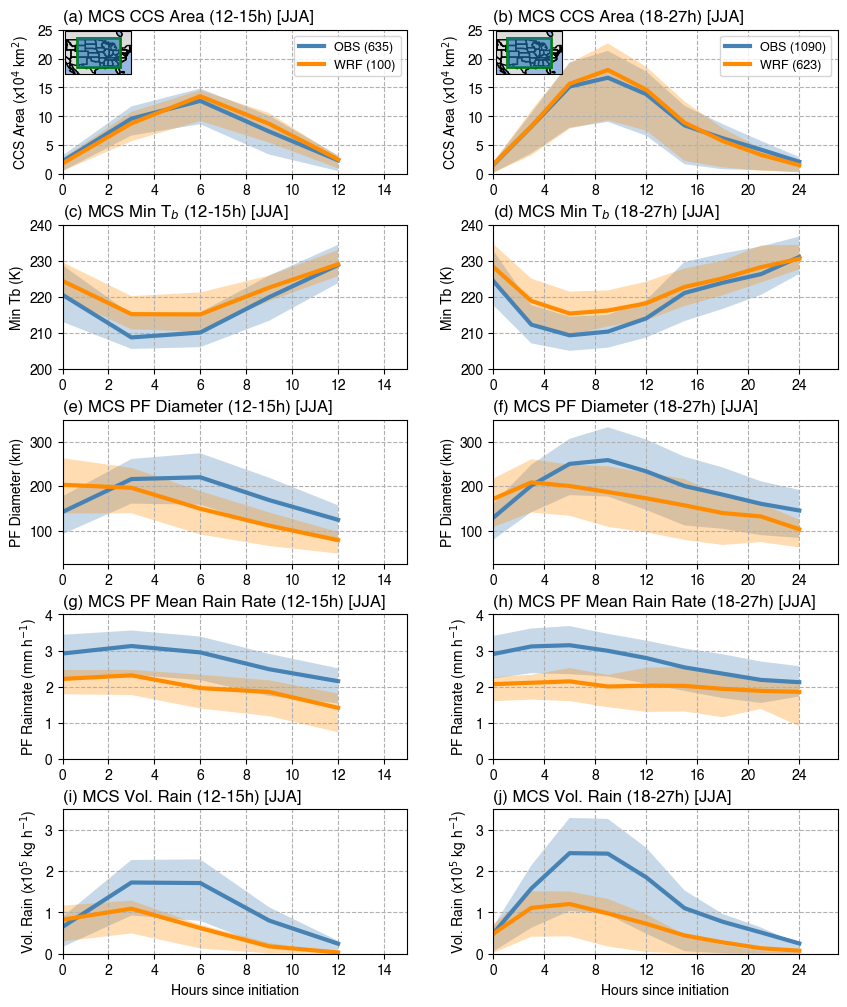

In [65]:
hours_obs = [avg1_ccsarea_l_obs_JJA.times * time_res_obs, avg2_ccsarea_l_obs_JJA.times * time_res_obs]
hours_m1 = [avg1_ccsarea_l_m1_JJA.times * time_res_m1, avg2_ccsarea_l_m1_JJA.times * time_res_m1]
dataavg_obs = [[avg1_ccsarea_l_obs_JJA/1e4, avg2_ccsarea_l_obs_JJA/1e4],
            [avg1_mintb_l_obs_JJA, avg2_mintb_l_obs_JJA],
            [avg1_pfdiam_l_obs_JJA, avg2_pfdiam_l_obs_JJA], 
            [avg1_pfrainrate_l_obs_JJA, avg2_pfrainrate_l_obs_JJA],
            [avg1_pfvolrain_l_obs_JJA/1e5, avg2_pfvolrain_l_obs_JJA/1e5]]
dataavg_m1 = [[avg1_ccsarea_l_m1_JJA/1e4, avg2_ccsarea_l_m1_JJA/1e4],
            [avg1_mintb_l_m1_JJA, avg2_mintb_l_m1_JJA],
            [avg1_pfdiam_l_m1_JJA, avg2_pfdiam_l_m1_JJA], 
            [avg1_pfrainrate_l_m1_JJA, avg2_pfrainrate_l_m1_JJA],
            [avg1_pfvolrain_l_m1_JJA/1e5, avg2_pfvolrain_l_m1_JJA/1e5]]
dataqntl_obs = [[(qntl1_ccsarea_l_obs_JJA.sel(quantile=0.25)/1e4,qntl1_ccsarea_l_obs_JJA.sel(quantile=0.75)/1e4), 
                 (qntl2_ccsarea_l_obs_JJA.sel(quantile=0.25)/1e4,qntl2_ccsarea_l_obs_JJA.sel(quantile=0.75)/1e4)],
                [(qntl1_mintb_l_obs_JJA.sel(quantile=0.25),qntl1_mintb_l_obs_JJA.sel(quantile=0.75)), 
                 (qntl2_mintb_l_obs_JJA.sel(quantile=0.25),qntl2_mintb_l_obs_JJA.sel(quantile=0.75))],
                [(qntl1_pfdiam_l_obs_JJA.sel(quantile=0.25),qntl1_pfdiam_l_obs_JJA.sel(quantile=0.75)), 
                 (qntl2_pfdiam_l_obs_JJA.sel(quantile=0.25),qntl2_pfdiam_l_obs_JJA.sel(quantile=0.75))],
                [(qntl1_pfrainrate_l_obs_JJA.sel(quantile=0.25),qntl1_pfrainrate_l_obs_JJA.sel(quantile=0.75)), 
                 (qntl2_pfrainrate_l_obs_JJA.sel(quantile=0.25),qntl2_pfrainrate_l_obs_JJA.sel(quantile=0.75))],
                [(qntl1_pfvolrain_l_obs_JJA.sel(quantile=0.25)/1e5,qntl1_pfvolrain_l_obs_JJA.sel(quantile=0.75)/1e5), 
                 (qntl2_pfvolrain_l_obs_JJA.sel(quantile=0.25)/1e5,qntl2_pfvolrain_l_obs_JJA.sel(quantile=0.75)/1e5)],]
dataqntl_m1 = [[(qntl1_ccsarea_l_m1_JJA.sel(quantile=0.25)/1e4,qntl1_ccsarea_l_m1_JJA.sel(quantile=0.75)/1e4), 
                 (qntl2_ccsarea_l_m1_JJA.sel(quantile=0.25)/1e4,qntl2_ccsarea_l_m1_JJA.sel(quantile=0.75)/1e4)],
                [(qntl1_mintb_l_m1_JJA.sel(quantile=0.25),qntl1_mintb_l_m1_JJA.sel(quantile=0.75)), 
                 (qntl2_mintb_l_m1_JJA.sel(quantile=0.25),qntl2_mintb_l_m1_JJA.sel(quantile=0.75))],
                [(qntl1_pfdiam_l_m1_JJA.sel(quantile=0.25),qntl1_pfdiam_l_m1_JJA.sel(quantile=0.75)), 
                 (qntl2_pfdiam_l_m1_JJA.sel(quantile=0.25),qntl2_pfdiam_l_m1_JJA.sel(quantile=0.75))],
                [(qntl1_pfrainrate_l_m1_JJA.sel(quantile=0.25),qntl1_pfrainrate_l_m1_JJA.sel(quantile=0.75)), 
                 (qntl2_pfrainrate_l_m1_JJA.sel(quantile=0.25),qntl2_pfrainrate_l_m1_JJA.sel(quantile=0.75))],
                [(qntl1_pfvolrain_l_m1_JJA.sel(quantile=0.25)/1e5,qntl1_pfvolrain_l_m1_JJA.sel(quantile=0.75)/1e5), 
                 (qntl2_pfvolrain_l_m1_JJA.sel(quantile=0.25)/1e5,qntl2_pfvolrain_l_m1_JJA.sel(quantile=0.75)/1e5)],]
ns_obs = [ns1_l_obs_JJA, ns2_l_obs_JJA]
ns_m1 = [ns1_l_m1_JJA, ns2_l_m1_JJA]
titles = []
titles = [[f'(a) MCS CCS Area ({lifetime_range1[0]}-{lifetime_range1[1]}h) [JJA]', f'(b) MCS CCS Area ({lifetime_range2[0]}-{lifetime_range2[1]}h) [JJA]'],
          [f'(c) MCS Min T$_b$ ({lifetime_range1[0]}-{lifetime_range1[1]}h) [JJA]', f'(d) MCS Min T$_b$ ({lifetime_range2[0]}-{lifetime_range2[1]}h) [JJA]'],
          [f'(e) MCS PF Diameter ({lifetime_range1[0]}-{lifetime_range1[1]}h) [JJA]', f'(f) MCS PF Diameter ({lifetime_range2[0]}-{lifetime_range2[1]}h) [JJA]'],
          [f'(g) MCS PF Mean Rain Rate ({lifetime_range1[0]}-{lifetime_range1[1]}h) [JJA]', f'(h) MCS PF Mean Rain Rate ({lifetime_range2[0]}-{lifetime_range2[1]}h) [JJA]'],
          [f'(i) MCS Vol. Rain ({lifetime_range1[0]}-{lifetime_range1[1]}h) [JJA]', f'(j) MCS Vol. Rain ({lifetime_range2[0]}-{lifetime_range2[1]}h) [JJA]']]
xlabels = ['','','','','Hours since initiation']
ylabels = ['CCS Area (x10$^{4}$ km$^2$)', 'Min Tb (K)', 'PF Diameter (km)', 'PF Rainrate (mm h$^{-1}$)', 'Vol. Rain (x10$^{5}$ kg h$^{-1}$)', ]
xticks = [np.arange(0, max(lifetime_range1)+1, 2), np.arange(0, max(lifetime_range2)+1, 4)]
xlims = [(0, max(lifetime_range1)), (0, max(lifetime_range2))]
#ylims = [(0,25), (190,235), (20,250), (2,14), (0,5)]
ylims = [(0,25), (200,240), (25,350), (0,4), (0,3.5)]
legends = [{'o':f'OBS ({ns1_l_obs_JJA})', 'm':f'WRF ({ns1_l_m1_JJA})'}, {'o':f'OBS ({ns2_l_obs_JJA})', 'm':f'WRF ({ns2_l_m1_JJA})'}]
figname = f'{figdir}mcs_composite_evolution_{region}_JJA.png'

bounds = [lon_bounds[0], lon_bounds[1]-0.1, lat_bounds[0], lat_bounds[1]]
map_extent = [bounds[0]-8,bounds[1]+8,bounds[2]-5,bounds[3]+5]
inset_param = {'width':'20%', 'height':'30%', 'loc':'upper left', 'borderpad':0.1}

fig = plot_evolution_mxn(5, 2, hours_obs, hours_m1, dataavg_obs, dataqntl_obs, dataavg_m1, dataqntl_m1, ns_obs, ns_m1,  
                          titles=titles, xlabels=xlabels, ylabels=ylabels, xticks=xticks, xlims=xlims, ylims=ylims, legends=legends, 
                          map_extent=map_extent, lon_bounds=lon_bounds, lat_bounds=lat_bounds, inset_param=inset_param, figname=figname, figsize=[10,12],
                          fontsize=10, legend_fontsize=9, legend_loc='upper right')

In [66]:
figdir

'/global/cfs/cdirs/m2637/zfeng/TGW_MCS/figures/'

In [67]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

## Set Seaborn plot style

In [68]:
sns.set_theme('talk', style='whitegrid', font_scale=1.3, 
              rc={'lines.linewidth':5, 'font.family':'Helvetica', 'axes.edgecolor':'k', 'grid.linestyle':'--'})
sns.axes_style()

{'axes.facecolor': 'white',
 'axes.edgecolor': 'k',
 'axes.grid': True,
 'axes.axisbelow': True,
 'axes.labelcolor': '.15',
 'figure.facecolor': 'white',
 'grid.color': '.8',
 'grid.linestyle': '--',
 'text.color': '.15',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'lines.solid_capstyle': <CapStyle.round: 'round'>,
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'font.family': ['Helvetica'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'xtick.bottom': False,
 'xtick.top': False,
 'ytick.left': False,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True}

## Function to plot 2D KDE

In [78]:
def plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, 
                   legend_loc='lower right', legend_labels=None):
#    mpl.rcParams['font.family'] = 'Helvetica'
    g = sns.JointGrid(height=8, ratio=5, space=.3, marginal_ticks=False, xlim=xlim, ylim=ylim)

    lcolors = {'obs':'steelblue', 'model':'darkorange'}
    # cmap = copy.copy(mpl.cm.get_cmap('Blues'))
    cmap = copy.copy(mpl.colormaps.get_cmap('Blues'))
    cmap = truncate_colormap(cmap, 0.1, 1)
    sns.kdeplot(x=x_obs, y=y_obs, levels=levels, fill=True, cmap=cmap, alpha=0.9, ax=g.ax_joint)
    sns.kdeplot(x=x_m1, y=y_m1, color=lcolors['model'], levels=levels, fill=False, ax=g.ax_joint)
    sns.kdeplot(x=x_obs, color=lcolors['obs'], ax=g.ax_marg_x)
    sns.kdeplot(x=x_m1, color=lcolors['model'], ax=g.ax_marg_x)
    sns.kdeplot(y=y_obs, color=lcolors['obs'], ax=g.ax_marg_y)
    sns.kdeplot(y=y_m1, color=lcolors['model'], ax=g.ax_marg_y)
    legend_elements = [mpl.patches.Patch(facecolor=lcolors['obs'], edgecolor='b'),
                       mpl.lines.Line2D([0], [0], color=lcolors['model'])]
    # legend_labels = ['OBS', f'{model_name[name_map["m1"]]}']
    leg = mpl.legend.Legend(g.ax_joint, handles=legend_elements, labels=legend_labels, 
                            loc=legend_loc, facecolor='w', prop={'family':'Helvetica', 'size':18})
    g.ax_joint.text(0.95, 0.95, annotate_text, ha='right', va='center', transform=g.ax_joint.transAxes)
    g.ax_joint.add_artist(leg)
    g.set_axis_labels(xlabel=xlabel, ylabel=ylabel)
    g.ax_marg_x.set_ylabel('')
    g.ax_marg_y.set_xlabel('')

    g.savefig(figname, dpi=300, facecolor='w')
    # sns.JointGrid(marginal_ticks=True)
    return g

## Land

In [79]:
levels = [0.1,0.2,0.4,0.6,0.8,1]
legend_labels = ['OBS', 'WRF']
# annotate_text = f'{region} (Land)'

In [80]:
ccslifetime_l_obs_JJA.shape, pfvolrain_l_obs_JJA.sum(dim='times').shape

((2329,), (2329,))

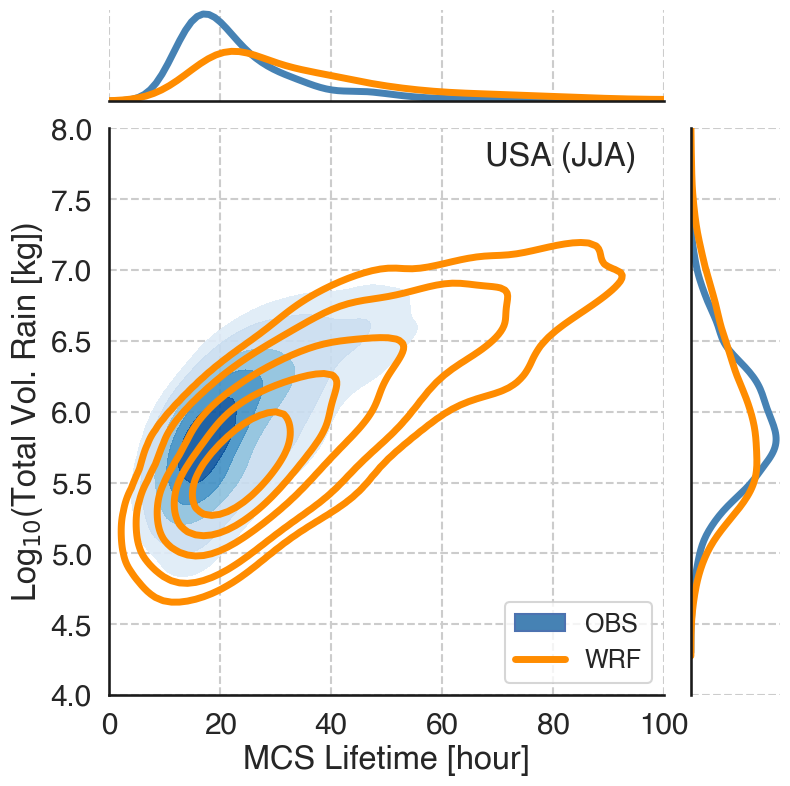

In [81]:
# x_obs, y_obs = (ds_nms_l_obs.track_duration * time_res_obs).data, np.log10(pfvolrain_l_obs).data
# x_m1, y_m1 = (ds_nms_l_m1.track_duration * time_res_m1).data, np.log10(pfvolrain_l_m1).data
x_obs, y_obs = ccslifetime_l_obs_JJA.data, np.log10(pfvolrain_l_obs_JJA.sum(dim='times')).data
x_m1, y_m1 = ccslifetime_l_m1_JJA.data, np.log10(pfvolrain_l_m1_JJA.sum(dim='times')).data
xlim = (0,100)
ylim = (4.0,8.0)
xlabel = 'MCS Lifetime [hour]'
ylabel = 'Log$_{10}$(Total Vol. Rain [kg])'
annotate_text = f'{region} (JJA)'
figname = f'{figdir}JointDist_Lifetime_Totalvolrain_{region}_obs_wrf_JJA.png'
g = plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, legend_labels=legend_labels)

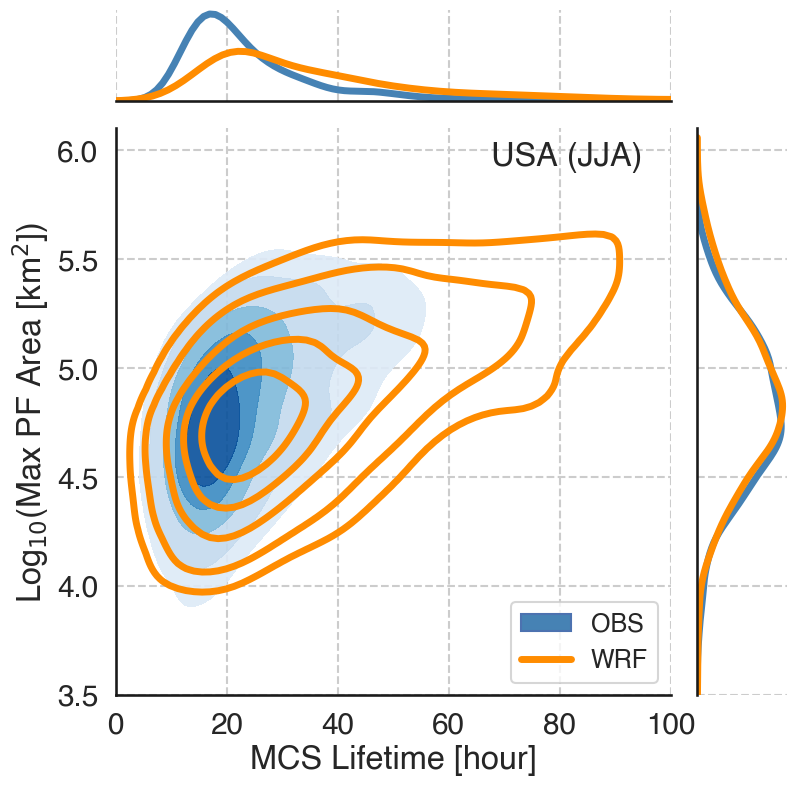

In [82]:
x_obs, y_obs = ccslifetime_l_obs_JJA.data, np.log10(ds_nms_l_obs.pf_area.max(dim=('times','nmaxpf')).where(start_season_obs == 'JJA', drop=True)).data
x_m1, y_m1 = ccslifetime_l_m1_JJA.data, np.log10(ds_nms_l_m1.pf_area.max(dim=('times','nmaxpf')).where(start_season_m1 == 'JJA', drop=True)).data
xlim = (0,100)
ylim = (3.5,6.1)
xlabel = 'MCS Lifetime [hour]'
ylabel = 'Log$_{10}$(Max PF Area [km$^2$])'
annotate_text = f'{region} (JJA)'
figname = f'{figdir}JointDist_Lifetime_PFarea_{region}_obs_wrf_JJA.png'
g = plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, legend_labels=legend_labels)

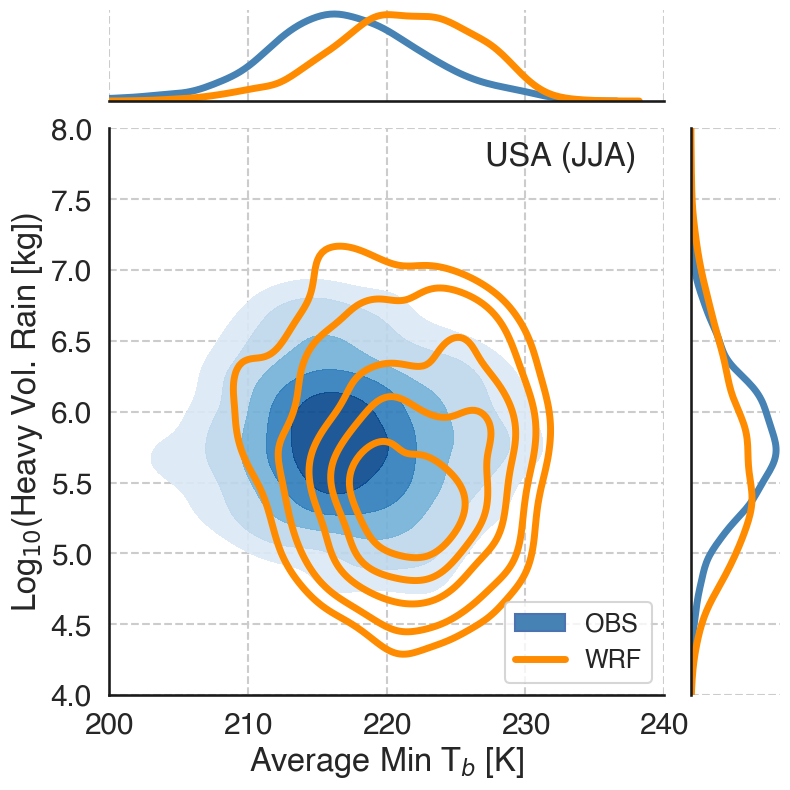

In [83]:
x_obs = ds_nms_l_obs.corecold_mintb.mean(dim='times').where(start_season_obs == 'JJA', drop=True).data
y_obs = np.log10(ds_nms_l_obs.total_heavyrain.sum(dim='times').where(start_season_obs == 'JJA', drop=True) * pixel_radius_obs**2)
x_m1 = ds_nms_l_m1.corecold_mintb.mean(dim='times').where(start_season_m1 == 'JJA', drop=True).data
y_m1 = np.log10(ds_nms_l_m1.total_heavyrain.sum(dim='times').where(start_season_m1 == 'JJA', drop=True) * pixel_radius_m1**2)
xlim = (200,240)
ylim = (4.,8)
xlabel = 'Average Min T$_b$ [K]'
ylabel = 'Log$_{10}$(Heavy Vol. Rain [kg])'
annotate_text = f'{region} (JJA)'
figname = f'{figdir}JointDist_MinTb_HeavyVolrain_{region}_obs_wrf_JJA.png'
g = plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, legend_labels=legend_labels)

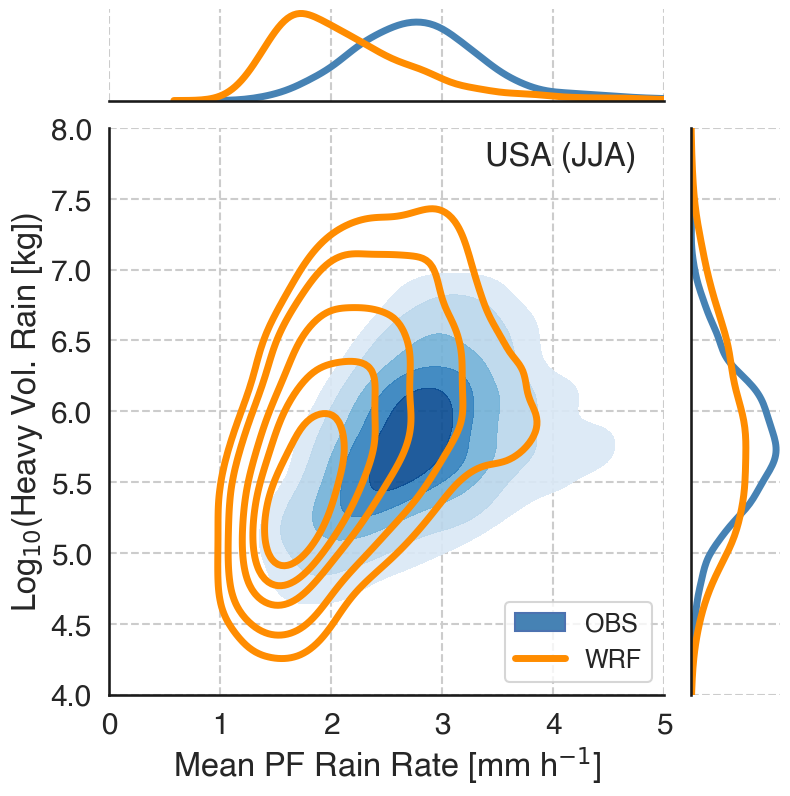

In [84]:
# Largest PF mean rain rate vs. Heavy Rain Volume
x_obs = ds_nms_l_obs.pf_rainrate.isel(nmaxpf=0).mean(dim='times').where(start_season_obs == 'JJA', drop=True).data
y_obs = np.log10(ds_nms_l_obs.total_heavyrain.sum(dim='times').where(start_season_obs == 'JJA', drop=True) * pixel_radius_obs**2)
x_m1 = ds_nms_l_m1.pf_rainrate.isel(nmaxpf=0).mean(dim='times').where(start_season_obs == 'JJA', drop=True).data
y_m1 = np.log10(ds_nms_l_m1.total_heavyrain.sum(dim='times').where(start_season_obs == 'JJA', drop=True) * pixel_radius_m1**2)
xlim = (0,5)
ylim = (4,8)
xlabel = 'Mean PF Rain Rate [mm h$^{-1}$]'
ylabel = 'Log$_{10}$(Heavy Vol. Rain [kg])'
annotate_text = f'{region} (JJA)'
figname = f'{figdir}JointDist_PFrainrate_HeavyVolrain_{region}_obs_wrf_JJA.png'
g = plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, legend_labels=legend_labels)

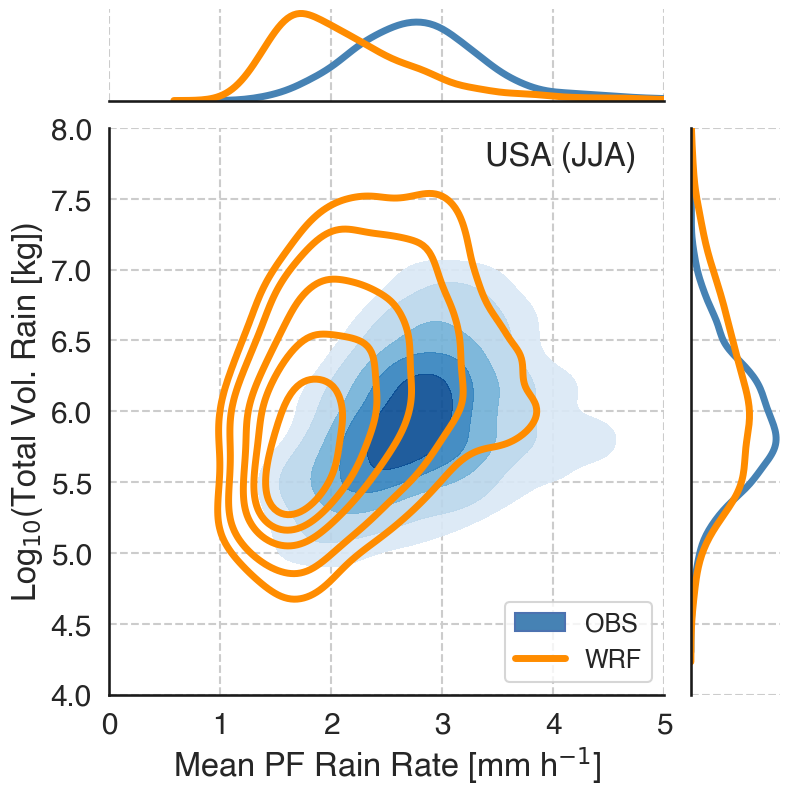

In [85]:
# Largest PF mean rain rate vs. Total Rain Volume
x_obs = ds_nms_l_obs.pf_rainrate.isel(nmaxpf=0).mean(dim='times').where(start_season_obs == 'JJA', drop=True).data
y_obs = np.log10(ds_nms_l_obs.total_rain.sum(dim='times').where(start_season_obs == 'JJA', drop=True) * pixel_radius_obs**2)
x_m1 = ds_nms_l_m1.pf_rainrate.isel(nmaxpf=0).mean(dim='times').where(start_season_obs == 'JJA', drop=True).data
y_m1 = np.log10(ds_nms_l_m1.total_rain.sum(dim='times').where(start_season_obs == 'JJA', drop=True) * pixel_radius_m1**2)
xlim = (0,5)
ylim = (4,8)
xlabel = 'Mean PF Rain Rate [mm h$^{-1}$]'
ylabel = 'Log$_{10}$(Total Vol. Rain [kg])'
annotate_text = f'{region} (JJA)'
figname = f'{figdir}JointDist_PFrainrate_TotalVolrain_{region}_obs_wrf_JJA.png'
g = plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, legend_labels=legend_labels)

In [86]:
figdir

'/global/cfs/cdirs/m2637/zfeng/TGW_MCS/figures/'